# HPC Anomaly Detection: GNN training

## Preliminary steps

In [1]:
! pip install dgl torch_geometric torchviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! if ! [ -d data ]; then cp -r drive/MyDrive/HPCDATA/data .; fi
! if ! [ -d utils ]; then cp -r drive/MyDrive/HPCDATA/utils .; fi

In [4]:
import itertools
import json
import logging
import os
import shutil
import random
from timeit import default_timer

import dgl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (auc, roc_curve, confusion_matrix,
                            ConfusionMatrixDisplay,precision_recall_curve,
                            classification_report)
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torchviz import make_dot

from utils.data_processing import *
from utils.training_simple import *

from tqdm.notebook import tqdm

## Reproducibility

In [5]:
RANDOM_SEED = None # Set a random seed to allow for reproducibility (it will slow down computations)

def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['CUBLAS_WORKSPACE_CONFIG']=':16:8'

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

g = None
if RANDOM_SEED is not None:
  g = torch.Generator()
  g.manual_seed(RANDOM_SEED)
  set_reproducibility(RANDOM_SEED)

In [6]:
AGGREGATED_METRICS_PATH = "data/aggregated/"
JOB_TABLE_PATH = 'data/job_table.parquet'
RACKS_DATA_PATH = 'data/racks_spatial_distribution.json'
WINDOW_SIZE = 10
DROP_TH = 100
KEEPNODES = np.arange(460,559).astype(str) # set it no None if you don't want to filter nodes

## Read and process Node Metrics

In [7]:
data = load_metrics(AGGREGATED_METRICS_PATH)
data = process_metrics(data,KEEPNODES,DROP_TH)
data = add_window_labels(data,WINDOW_SIZE)
data.head()

## Read Jobs and Racks Tables

In [11]:
node_columns = data.columns[1:-3]
nodes = list(node_columns.astype(int))

racks = pd.read_json(RACKS_DATA_PATH)

jobtable = pd.read_parquet(JOB_TABLE_PATH)[['start_time','end_time','nodes']]
jobtable = jobtable.dropna(subset=['nodes'])
jobtable.nodes = jobtable.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
jobtable.nodes = jobtable.nodes.map(lambda a : np.intersect1d(a,nodes)) # Keep only jobs where the selected nodes appear
jobtable = jobtable[jobtable.nodes.map(len)>0] # Drop rows without any node of interest
jobtable = jobtable.reset_index() # Not really necessary, but meh
print("Data covering the period from {} to {}".format(jobtable.start_time.min().date(),jobtable.end_time.max().date()))
jobtable.head()

SyntaxError: ignored

## Create graphs

In [ ]:
def build_graph(jobs):
  edge_list = jobs.nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
  edge_list = edge_list[edge_list.map(len) > 0]
  if len(edge_list) > 0:
    true_edges = np.concatenate(edge_list.values) # remove empty list and collect all
    heatmap = build_heatmap(true_edges)

  else:
    heatmap = np.zeros((980,980))
    true_edges = np.empty(0)

  src,dst = np.nonzero(heatmap)
  graph = dgl.graph((src,dst),num_nodes=980)

  eweights = torch.tensor(heatmap[heatmap.nonzero()],dtype=torch.float32)

  graph = dgl.graph((src,dst),num_nodes=980)
  graph.edata['eweight'] = eweights


  # Drop nodes not contained in the dataset
  drop_nids = [i for i in range(980) if str(i) not in data.columns]
  graph = dgl.remove_nodes(graph, drop_nids, store_ids=True)

  # Add self loops
  graph = dgl.add_self_loop(graph)
  return graph

In [9]:
data_list = []

for i,row in tqdm(data.iterrows(), total=len(data)):
    timestamp = row['timestamp']
    jobs = jobtable[(jobtable['start_time']<timestamp) & (jobtable['end_time']>timestamp)]
    if len(jobs) > 0:
      graph = build_graph(jobs)
      # Graph changes, so are the weights
      eweights = graph.edata['eweight']
      edge_index = torch.stack(graph.edges())
      x = torch.tensor(np.stack(row.iloc[1:-3]),dtype = torch.float32)
      y = torch.tensor(row.iloc[-1],dtype=torch.float32)
      g = Data(edge_index=edge_index,x=x, y=y,edge_weight = eweights)
      data_list.append(g)

# data = data[:len(data)-WINDOW_SIZE].drop(['values','anomalies'],axis=1)

  0%|          | 0/2963 [00:00<?, ?it/s]

NameError: ignored

## Train/Test split

In [ ]:
TRAIN_SPLIT = 0.7

train_size = int(len(data)*TRAIN_SPLIT)
train_data = data_list[:train_size]
test_data = data_list[train_size:]

# del data

## Model Definition & Training Setup

In [ ]:
class anomaly_anticipation(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #encoder
        self.conv1 = GCNConv(in_channels, 300)
        self.conv2 = GCNConv(300, 100)
        self.conv3 = GCNConv(100, out_channels)

        #dense layer
        self.fc1 = torch.nn.Linear(out_channels,16)
        self.fc2 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index,edge_weight=None):
        x = self.conv1(x, edge_index,edge_weight).relu()
        x = self.conv2(x, edge_index,edge_weight).relu()
        x = self.conv3(x, edge_index,edge_weight).relu()
        x = self.fc1(x)
        x = self.fc2(x)
        return x

conv1.bias torch.Size([300]) 300
conv1.lin.weight torch.Size([300, 416]) 124800
conv2.bias torch.Size([100]) 100
conv2.lin.weight torch.Size([100, 300]) 30000
conv3.bias torch.Size([16]) 16
conv3.lin.weight torch.Size([16, 100]) 1600
fc1.weight torch.Size([16, 16]) 256
fc1.bias torch.Size([16]) 16
fc2.weight torch.Size([1, 16]) 16
fc2.bias torch.Size([1]) 1
Total trainable Params: 157105


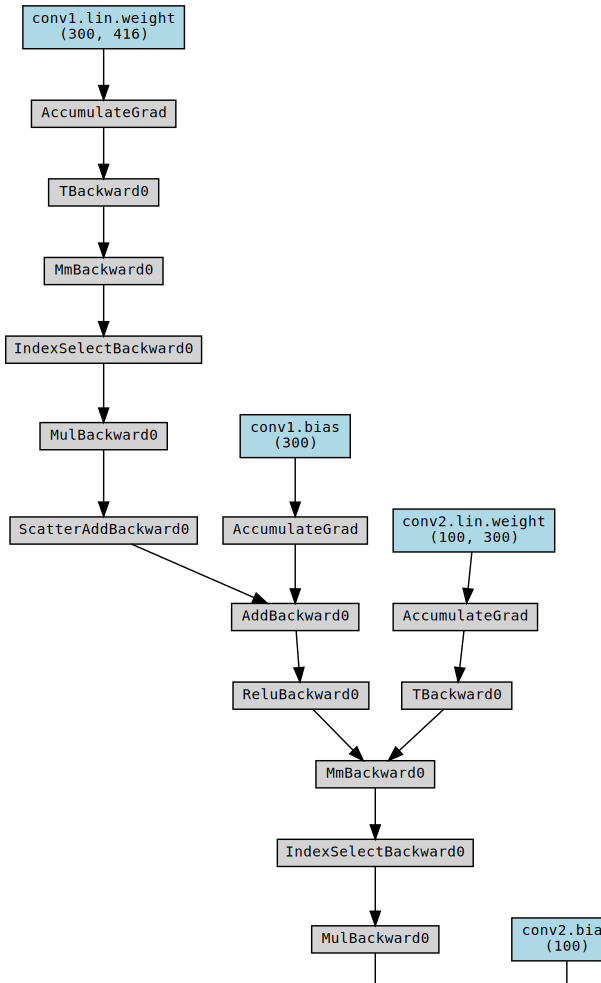

In [ ]:
# Create model
in_channels, out_channels = train_data[0].x.shape[1], 16
model = anomaly_anticipation(in_channels,out_channels)

tot_params = 0
for name,param in model.named_parameters():
    print(name,param.shape,param.numel())
    tot_params += param.numel()
print('Total trainable Params:',tot_params)

# Make a forward pass
g = train_data[0]
x = g.x
out = model (x,g.edge_index,g.edge_weight)

# Backtrack to draw the computational graph
make_dot(out, params=dict(list(model.named_parameters())))

## Train

In [ ]:
NUM_EPOCHS = 200
INITIAL_LR = 1e-3

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

ES_PATIENCE = 50
ES_MIN_DELTA = 0
LOGGER_NAME = f'out/train.output'
LOGPATH = f'out'

APPLY_WEIGHT_BALANCING = True # whether to use weight balancing inside the loss

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device:',device)

model = model.to(device)

# Prepare dataloaders
train_loader = DataLoader(train_data, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)

# Compute weight balancing
pos_weight = None
if APPLY_WEIGHT_BALANCING:
  train_labels = torch.cat([g.y for g in train_data])
  train_ones = len(train_labels.nonzero())
  train_zeros = len(train_labels)-train_ones
  pos_weight = torch.tensor(train_zeros/train_ones) * 100
  # pos_weight = torch.tensor(train_ones/train_zeros)


# Set up training
criterion = torch.nn.BCEWithLogitsLoss(weight = pos_weight)
optimizer = torch.optim.Adam([p for p in model.parameters()],lr = INITIAL_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=INITIAL_LR * 1e-1)
trainer =  MyTrainer(model,
                     optimizer,
                     scheduler,
                     ES_PATIENCE,
                     ES_MIN_DELTA)


Available device: cuda


In [ ]:
# Train
trainer.train(NUM_EPOCHS,criterion,train_loader,LOGGER_NAME,device,LOGPATH)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/500	 Train Loss: 2695.1631917888694, Train Acc at 50%: 0.9905784812511776


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/500	 Train Loss: 578.9991465212428, Train Acc at 50%: 0.9909331737217216


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/500	 Train Loss: 495.4123189128676, Train Acc at 50%: 0.9909331737217216


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/500	 Train Loss: 445.12140458218335, Train Acc at 50%: 0.9909331737217216


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/500	 Train Loss: 378.61337412296746, Train Acc at 50%: 0.9909331737217216


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/500	 Train Loss: 290.2976534876246, Train Acc at 50%: 0.9909331737217216


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/500	 Train Loss: 216.6196477460402, Train Acc at 50%: 0.993083496824394


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/500	 Train Loss: 179.5651802835323, Train Acc at 50%: 0.9958767000299272


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/500	 Train Loss: 164.0076369722564, Train Acc at 50%: 0.9965362063423447


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/500	 Train Loss: 155.07531672929207, Train Acc at 50%: 0.996541748412197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/500	 Train Loss: 151.653487624558, Train Acc at 50%: 0.9961981400813575


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/500	 Train Loss: 153.6335140048105, Train Acc at 50%: 0.9959376627983019


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/500	 Train Loss: 149.45252108757578, Train Acc at 50%: 0.9957048958645075


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/500	 Train Loss: 148.66341901373326, Train Acc at 50%: 0.9955109234196787


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/500	 Train Loss: 144.16969817887585, Train Acc at 50%: 0.9953502033939636


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/500	 Train Loss: 137.42939957215222, Train Acc at 50%: 0.9959321207284496


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/500	 Train Loss: 137.16592957137632, Train Acc at 50%: 0.9968964408827409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/500	 Train Loss: 131.87328611489818, Train Acc at 50%: 0.9969407774415588


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/500	 Train Loss: 128.79870093882664, Train Acc at 50%: 0.9963810283864818


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/500	 Train Loss: 127.59435373923453, Train Acc at 50%: 0.9963089814784025


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21/500	 Train Loss: 131.0697524911604, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/500	 Train Loss: 129.67259668140858, Train Acc at 50%: 0.9972345071437281


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23/500	 Train Loss: 128.33261286425255, Train Acc at 50%: 0.9965029539232313


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24/500	 Train Loss: 124.97375275717975, Train Acc at 50%: 0.9964807856438223


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/500	 Train Loss: 132.7606601713608, Train Acc at 50%: 0.9970793291878651


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/500	 Train Loss: 129.91501790088563, Train Acc at 50%: 0.997500526496636


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/500	 Train Loss: 128.3931655194582, Train Acc at 50%: 0.9966913842982077


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/500	 Train Loss: 124.67450315343774, Train Acc at 50%: 0.9961371773129829


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/500	 Train Loss: 128.19552422438733, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/500	 Train Loss: 128.1503563550915, Train Acc at 50%: 0.9975226947760449


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31/500	 Train Loss: 126.48069697070461, Train Acc at 50%: 0.996541748412197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32/500	 Train Loss: 123.20353805739367, Train Acc at 50%: 0.9961648876622441


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33/500	 Train Loss: 126.18398563495494, Train Acc at 50%: 0.9974839002870792


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/500	 Train Loss: 125.49036234052694, Train Acc at 50%: 0.9974728161473747


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35/500	 Train Loss: 125.50169033130494, Train Acc at 50%: 0.9964697015041177


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/500	 Train Loss: 121.953901062969, Train Acc at 50%: 0.9960651304049036


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/500	 Train Loss: 127.82068078786065, Train Acc at 50%: 0.9972843857723983


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38/500	 Train Loss: 125.28440794067768, Train Acc at 50%: 0.9975337789157495


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39/500	 Train Loss: 124.03610104301755, Train Acc at 50%: 0.9965639166916059


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40/500	 Train Loss: 119.9142198428269, Train Acc at 50%: 0.9963089814784025


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 41/500	 Train Loss: 124.24885002050566, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/500	 Train Loss: 122.77528015163104, Train Acc at 50%: 0.9974839002870792


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/500	 Train Loss: 120.727119564615, Train Acc at 50%: 0.996519580132788


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44/500	 Train Loss: 118.38790055309858, Train Acc at 50%: 0.9964031966658907


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45/500	 Train Loss: 122.10756049169244, Train Acc at 50%: 0.9974561899378179


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 46/500	 Train Loss: 120.97342023298862, Train Acc at 50%: 0.9971181236768308


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47/500	 Train Loss: 117.96428690187211, Train Acc at 50%: 0.9965306642724925


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48/500	 Train Loss: 117.00808033784458, Train Acc at 50%: 0.9968576463937752


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/500	 Train Loss: 120.63973220718474, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 50/500	 Train Loss: 119.29854021880092, Train Acc at 50%: 0.9971624602356488


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 51/500	 Train Loss: 116.53219388377171, Train Acc at 50%: 0.996608253250424


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 52/500	 Train Loss: 115.65809862667508, Train Acc at 50%: 0.9967246367173211


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 53/500	 Train Loss: 119.06431017856549, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 54/500	 Train Loss: 118.5425243019763, Train Acc at 50%: 0.9969906560702291


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 55/500	 Train Loss: 115.2730910340394, Train Acc at 50%: 0.9966747580886509


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 56/500	 Train Loss: 114.57643068533235, Train Acc at 50%: 0.9969906560702291


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 57/500	 Train Loss: 115.8166129085891, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 58/500	 Train Loss: 115.71486050610181, Train Acc at 50%: 0.9968354781143661


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 59/500	 Train Loss: 113.14523548254802, Train Acc at 50%: 0.9966913842982077


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 60/500	 Train Loss: 114.83818264445405, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 61/500	 Train Loss: 115.44890765803213, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 62/500	 Train Loss: 113.05280484155222, Train Acc at 50%: 0.9969684877908201


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 63/500	 Train Loss: 111.56843902060541, Train Acc at 50%: 0.9971901705849101


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 64/500	 Train Loss: 114.92746538977377, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 65/500	 Train Loss: 115.65754441968987, Train Acc at 50%: 0.9967246367173211


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 66/500	 Train Loss: 110.25393764063003, Train Acc at 50%: 0.9968299360445139


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 67/500	 Train Loss: 111.39295492080382, Train Acc at 50%: 0.997389685099591


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 68/500	 Train Loss: 112.59071814141146, Train Acc at 50%: 0.9971735443753533


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 69/500	 Train Loss: 109.86078320531152, Train Acc at 50%: 0.9969352353717066


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 70/500	 Train Loss: 110.7621565302209, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 71/500	 Train Loss: 110.84080958556402, Train Acc at 50%: 0.9970239084893426


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 72/500	 Train Loss: 107.55861847282723, Train Acc at 50%: 0.9969463195114111


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 73/500	 Train Loss: 112.04802757733958, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 74/500	 Train Loss: 111.45560247841364, Train Acc at 50%: 0.9969851140003768


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 75/500	 Train Loss: 107.16166217759009, Train Acc at 50%: 0.996874272603332


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 76/500	 Train Loss: 108.57936798235404, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 77/500	 Train Loss: 109.93435972466997, Train Acc at 50%: 0.9971901705849101


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 78/500	 Train Loss: 107.83920238530686, Train Acc at 50%: 0.9972400492135803


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 79/500	 Train Loss: 107.5171527061927, Train Acc at 50%: 0.997278843702546


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 80/500	 Train Loss: 106.41104423680156, Train Acc at 50%: 0.9972899278422506


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 81/500	 Train Loss: 106.57245147917844, Train Acc at 50%: 0.997301011981955


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 82/500	 Train Loss: 105.53851184340327, Train Acc at 50%: 0.9971125816069786


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 83/500	 Train Loss: 104.8664139482814, Train Acc at 50%: 0.9973453485407731


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 84/500	 Train Loss: 105.85992972655427, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 85/500	 Train Loss: 104.09786186945101, Train Acc at 50%: 0.996874272603332


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 86/500	 Train Loss: 102.96639288841597, Train Acc at 50%: 0.9971735443753533


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 87/500	 Train Loss: 104.74750329753157, Train Acc at 50%: 0.9973786009598865


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 88/500	 Train Loss: 107.2201199303916, Train Acc at 50%: 0.9966581318790942


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 89/500	 Train Loss: 100.64990744743346, Train Acc at 50%: 0.9970793291878651


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 90/500	 Train Loss: 104.66504838226982, Train Acc at 50%: 0.9972622174929893


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 91/500	 Train Loss: 106.68016714882674, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 92/500	 Train Loss: 103.69881067180971, Train Acc at 50%: 0.9971292078165354


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 93/500	 Train Loss: 102.39146964608342, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 94/500	 Train Loss: 103.05488865981667, Train Acc at 50%: 0.9972677595628415


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 95/500	 Train Loss: 101.64813398508075, Train Acc at 50%: 0.997278843702546


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 96/500	 Train Loss: 99.29304248550748, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 97/500	 Train Loss: 98.0517851006994, Train Acc at 50%: 0.9973120961216595


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 98/500	 Train Loss: 97.82366242144116, Train Acc at 50%: 0.9970737871180129


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 99/500	 Train Loss: 97.65722297963843, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 100/500	 Train Loss: 97.48959753488732, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 101/500	 Train Loss: 96.35677628880835, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 102/500	 Train Loss: 96.21786985003159, Train Acc at 50%: 0.9972067967944668


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 103/500	 Train Loss: 97.17658142963234, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 104/500	 Train Loss: 99.20373757190836, Train Acc at 50%: 0.9968576463937752


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 105/500	 Train Loss: 96.50026047728305, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 106/500	 Train Loss: 95.61406133962913, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 107/500	 Train Loss: 95.90843392190115, Train Acc at 50%: 0.9972400492135803


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 108/500	 Train Loss: 95.06198250922755, Train Acc at 50%: 0.9972178809341713


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 109/500	 Train Loss: 94.07644731154191, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 110/500	 Train Loss: 94.02277790709275, Train Acc at 50%: 0.9969906560702291


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 111/500	 Train Loss: 91.68008401777897, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 112/500	 Train Loss: 91.1961892727696, Train Acc at 50%: 0.9973287223312163


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 113/500	 Train Loss: 91.39519945909399, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 114/500	 Train Loss: 91.8321196200357, Train Acc at 50%: 0.996763431206287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 115/500	 Train Loss: 89.65329919418305, Train Acc at 50%: 0.9972899278422506


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 116/500	 Train Loss: 90.96327270308915, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 117/500	 Train Loss: 91.25358294815948, Train Acc at 50%: 0.996874272603332


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 118/500	 Train Loss: 88.58793602234563, Train Acc at 50%: 0.997367516820182


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 119/500	 Train Loss: 89.4102738890921, Train Acc at 50%: 0.9972400492135803


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 120/500	 Train Loss: 88.3538556179962, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 121/500	 Train Loss: 88.67295691594897, Train Acc at 50%: 0.9971181236768308


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 122/500	 Train Loss: 87.32261497023909, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 123/500	 Train Loss: 88.16969817887585, Train Acc at 50%: 0.9972234230040236


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 124/500	 Train Loss: 86.68683980092885, Train Acc at 50%: 0.997367516820182


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 125/500	 Train Loss: 87.01682018200158, Train Acc at 50%: 0.9971347498863876


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 126/500	 Train Loss: 85.30917545084738, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 127/500	 Train Loss: 85.78266218867422, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 128/500	 Train Loss: 86.39705051042463, Train Acc at 50%: 0.9971070395371263


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 129/500	 Train Loss: 84.48396679191744, Train Acc at 50%: 0.9972899278422506


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 130/500	 Train Loss: 85.92902825347211, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 131/500	 Train Loss: 85.92822465334353, Train Acc at 50%: 0.9967357208570257


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 132/500	 Train Loss: 84.10270009643202, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 133/500	 Train Loss: 85.29862889191855, Train Acc at 50%: 0.9971569181657965


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 134/500	 Train Loss: 84.32627273634156, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 135/500	 Train Loss: 84.398424943748, Train Acc at 50%: 0.9972677595628415


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 136/500	 Train Loss: 83.45250446136623, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 137/500	 Train Loss: 83.55080969640541, Train Acc at 50%: 0.9972234230040236


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 138/500	 Train Loss: 82.86258992008335, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 139/500	 Train Loss: 83.45690486482891, Train Acc at 50%: 0.9972899278422506


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 140/500	 Train Loss: 82.51771799731763, Train Acc at 50%: 0.9971735443753533


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 141/500	 Train Loss: 81.5702291091677, Train Acc at 50%: 0.997367516820182


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 142/500	 Train Loss: 84.67046298451545, Train Acc at 50%: 0.9970571609084561


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 143/500	 Train Loss: 82.61641117724648, Train Acc at 50%: 0.9971957126547623


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 144/500	 Train Loss: 82.82262605437879, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 145/500	 Train Loss: 85.1614294106563, Train Acc at 50%: 0.996497411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 146/500	 Train Loss: 83.256714217626, Train Acc at 50%: 0.9972843857723983


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 147/500	 Train Loss: 83.40084682827343, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 148/500	 Train Loss: 83.55880136113235, Train Acc at 50%: 0.9967412629268779


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 149/500	 Train Loss: 83.07367073454594, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 150/500	 Train Loss: 82.21421762599896, Train Acc at 50%: 0.997278843702546


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 151/500	 Train Loss: 84.7072734124741, Train Acc at 50%: 0.9971569181657965


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 152/500	 Train Loss: 82.03691018521597, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 153/500	 Train Loss: 82.33543377780734, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 154/500	 Train Loss: 81.969579578581, Train Acc at 50%: 0.9972455912834325


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 155/500	 Train Loss: 82.69539675678072, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 156/500	 Train Loss: 81.95646704131059, Train Acc at 50%: 0.9971680023055011


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 157/500	 Train Loss: 82.38673117635975, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 158/500	 Train Loss: 82.55846883694122, Train Acc at 50%: 0.997212338864319


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 159/500	 Train Loss: 83.815604251876, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 160/500	 Train Loss: 82.57014597811991, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 161/500	 Train Loss: 83.10737760338732, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 162/500	 Train Loss: 83.6807878606502, Train Acc at 50%: 0.9973287223312163


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 163/500	 Train Loss: 82.74777485895432, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 164/500	 Train Loss: 82.27094625300657, Train Acc at 50%: 0.9971624602356488


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 165/500	 Train Loss: 84.29927177202141, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 166/500	 Train Loss: 83.84104789456767, Train Acc at 50%: 0.9970072822797859


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 167/500	 Train Loss: 83.13498819539122, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 168/500	 Train Loss: 84.08520932397832, Train Acc at 50%: 0.9971957126547623


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 169/500	 Train Loss: 83.24994180826656, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 170/500	 Train Loss: 84.44067214223168, Train Acc at 50%: 0.9970571609084561


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 171/500	 Train Loss: 83.41941830434831, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 172/500	 Train Loss: 85.28611489819218, Train Acc at 50%: 0.9972234230040236


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 173/500	 Train Loss: 85.5077533557233, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 174/500	 Train Loss: 83.65760538245824, Train Acc at 50%: 0.9968798146731841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 175/500	 Train Loss: 85.05997627994103, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 176/500	 Train Loss: 86.91872554561678, Train Acc at 50%: 0.9971680023055011


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 177/500	 Train Loss: 84.62206408849578, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 178/500	 Train Loss: 85.48311885523005, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 179/500	 Train Loss: 92.22760726676199, Train Acc at 50%: 0.9968299360445139


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 180/500	 Train Loss: 82.9261630033585, Train Acc at 50%: 0.9972345071437281


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 181/500	 Train Loss: 84.88765670202507, Train Acc at 50%: 0.9973786009598865


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 182/500	 Train Loss: 86.58939912878662, Train Acc at 50%: 0.9972899278422506


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 183/500	 Train Loss: 83.97598621133021, Train Acc at 50%: 0.9972289650738758


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 184/500	 Train Loss: 84.4502211285871, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 185/500	 Train Loss: 86.05757656369501, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 186/500	 Train Loss: 83.8783903612321, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 187/500	 Train Loss: 83.94134827475365, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 188/500	 Train Loss: 82.90686551613297, Train Acc at 50%: 0.997256675423137


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 189/500	 Train Loss: 79.92500471075938, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 190/500	 Train Loss: 84.3615868054401, Train Acc at 50%: 0.9969352353717066


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 191/500	 Train Loss: 90.0569613939414, Train Acc at 50%: 0.9972622174929893


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 192/500	 Train Loss: 82.29296489652955, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 193/500	 Train Loss: 84.0012303395072, Train Acc at 50%: 0.9968576463937752


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 194/500	 Train Loss: 81.80433168179651, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 195/500	 Train Loss: 82.09950786419712, Train Acc at 50%: 0.9972677595628415


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 196/500	 Train Loss: 80.35945310854699, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 197/500	 Train Loss: 79.26702246755119, Train Acc at 50%: 0.9971735443753533


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 198/500	 Train Loss: 78.10512198095745, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 199/500	 Train Loss: 78.10148084106451, Train Acc at 50%: 0.9973120961216595


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 200/500	 Train Loss: 77.64529090324655, Train Acc at 50%: 0.997278843702546


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 201/500	 Train Loss: 77.33650893935867, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 202/500	 Train Loss: 77.97470045112449, Train Acc at 50%: 0.9971846285150578


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 203/500	 Train Loss: 77.14862168722775, Train Acc at 50%: 0.9973287223312163


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 204/500	 Train Loss: 77.2137132976424, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 205/500	 Train Loss: 77.93301300169587, Train Acc at 50%: 0.9971014974672741


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 206/500	 Train Loss: 76.95965373147563, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 207/500	 Train Loss: 77.64658220552212, Train Acc at 50%: 0.997367516820182


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 208/500	 Train Loss: 77.51882641128809, Train Acc at 50%: 0.997389685099591


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 209/500	 Train Loss: 78.05769848923175, Train Acc at 50%: 0.9972289650738758


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 210/500	 Train Loss: 77.2187621232778, Train Acc at 50%: 0.9973453485407731


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 211/500	 Train Loss: 77.97709462530065, Train Acc at 50%: 0.9971624602356488


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 212/500	 Train Loss: 76.72634367483568, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 213/500	 Train Loss: 77.59720790520844, Train Acc at 50%: 0.997301011981955


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 214/500	 Train Loss: 76.72912025183166, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 215/500	 Train Loss: 77.41614848313549, Train Acc at 50%: 0.9971513760959443


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 216/500	 Train Loss: 76.31992706636075, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 217/500	 Train Loss: 77.01660958334719, Train Acc at 50%: 0.9973508906106252


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 218/500	 Train Loss: 76.58770325541182, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 219/500	 Train Loss: 76.54920249614827, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 220/500	 Train Loss: 76.26907303339651, Train Acc at 50%: 0.9973786009598865


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 221/500	 Train Loss: 77.52312151542358, Train Acc at 50%: 0.9970848712577174


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 222/500	 Train Loss: 76.27654374355734, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 223/500	 Train Loss: 76.67300125250779, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 224/500	 Train Loss: 76.71833538389917, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 225/500	 Train Loss: 76.26110907901884, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 226/500	 Train Loss: 76.21412341081147, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 227/500	 Train Loss: 75.87841807158138, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 228/500	 Train Loss: 76.02340416098605, Train Acc at 50%: 0.9972843857723983


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 229/500	 Train Loss: 75.9832518649065, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 230/500	 Train Loss: 76.0311741429189, Train Acc at 50%: 0.9972178809341713


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 231/500	 Train Loss: 75.09471951584477, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 232/500	 Train Loss: 75.90278101065186, Train Acc at 50%: 0.9973120961216595


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 233/500	 Train Loss: 75.31299947904543, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 234/500	 Train Loss: 75.7949434154668, Train Acc at 50%: 0.9972733016326938


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 235/500	 Train Loss: 75.41063412363249, Train Acc at 50%: 0.9974229375187045


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 236/500	 Train Loss: 76.13031068843591, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 237/500	 Train Loss: 75.36364845542514, Train Acc at 50%: 0.997389685099591


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 238/500	 Train Loss: 77.90739201276892, Train Acc at 50%: 0.997034992629047


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 239/500	 Train Loss: 76.3736796018577, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 240/500	 Train Loss: 76.60763808067037, Train Acc at 50%: 0.9974395637282613


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 241/500	 Train Loss: 76.38150500448907, Train Acc at 50%: 0.9973287223312163


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 242/500	 Train Loss: 75.14112326671766, Train Acc at 50%: 0.9974395637282613


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 243/500	 Train Loss: 76.0566953745885, Train Acc at 50%: 0.9972677595628415


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 244/500	 Train Loss: 74.88880391048448, Train Acc at 50%: 0.9973287223312163


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 245/500	 Train Loss: 74.99270663607444, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 246/500	 Train Loss: 74.99436371496026, Train Acc at 50%: 0.9972455912834325


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 247/500	 Train Loss: 74.60555980447577, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 248/500	 Train Loss: 75.64817277956972, Train Acc at 50%: 0.9972733016326938


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 249/500	 Train Loss: 74.5051873773817, Train Acc at 50%: 0.997301011981955


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 250/500	 Train Loss: 74.39616377924827, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 251/500	 Train Loss: 74.65517241379311, Train Acc at 50%: 0.9973342644010685


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 252/500	 Train Loss: 75.30351699752823, Train Acc at 50%: 0.9972733016326938


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 253/500	 Train Loss: 74.35203781908467, Train Acc at 50%: 0.997389685099591


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 254/500	 Train Loss: 75.08292599119919, Train Acc at 50%: 0.997301011981955


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 255/500	 Train Loss: 74.75659229208925, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 256/500	 Train Loss: 74.80445914940312, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 257/500	 Train Loss: 74.57643068533235, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 258/500	 Train Loss: 75.52459570600428, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 259/500	 Train Loss: 75.12585486427471, Train Acc at 50%: 0.997367516820182


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 260/500	 Train Loss: 74.71957126547623, Train Acc at 50%: 0.9973398064709208


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 261/500	 Train Loss: 74.31762710737206, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 262/500	 Train Loss: 74.19680998459305, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 263/500	 Train Loss: 74.25895875591615, Train Acc at 50%: 0.9973120961216595


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 264/500	 Train Loss: 73.84216185060797, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 265/500	 Train Loss: 73.41676365288907, Train Acc at 50%: 0.9973564326804775


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 266/500	 Train Loss: 73.55587514825037, Train Acc at 50%: 0.9972954699121027


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 267/500	 Train Loss: 72.89381948370077, Train Acc at 50%: 0.9974063113091477


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 268/500	 Train Loss: 73.8978319422738, Train Acc at 50%: 0.9972843857723983


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 269/500	 Train Loss: 72.95604584400182, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 270/500	 Train Loss: 73.74337999756149, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 271/500	 Train Loss: 73.78299471286536, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 272/500	 Train Loss: 74.25427570689101, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 273/500	 Train Loss: 73.86927919839502, Train Acc at 50%: 0.9974617320076702


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 274/500	 Train Loss: 73.86217426484444, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 275/500	 Train Loss: 73.69135104578858, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 276/500	 Train Loss: 73.16323612542813, Train Acc at 50%: 0.9974007692392954


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 277/500	 Train Loss: 73.09447012270142, Train Acc at 50%: 0.997278843702546


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 278/500	 Train Loss: 72.7293363925559, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 279/500	 Train Loss: 72.29887274299205, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 280/500	 Train Loss: 73.04983983418127, Train Acc at 50%: 0.9972511333532847


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 281/500	 Train Loss: 71.58893359491903, Train Acc at 50%: 0.9974561899378179


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 282/500	 Train Loss: 72.38793380551769, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 283/500	 Train Loss: 72.52176925037963, Train Acc at 50%: 0.9973176381915118


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 284/500	 Train Loss: 72.1838858776976, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 285/500	 Train Loss: 71.8903113534843, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 286/500	 Train Loss: 72.69424954832131, Train Acc at 50%: 0.9973065540518072


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 287/500	 Train Loss: 72.38554517341136, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 288/500	 Train Loss: 72.53519214356177, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 289/500	 Train Loss: 72.66194482315255, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 290/500	 Train Loss: 72.65440760815349, Train Acc at 50%: 0.997323180261364


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 291/500	 Train Loss: 71.87092519314113, Train Acc at 50%: 0.9974395637282613


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 292/500	 Train Loss: 72.59447012270142, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 293/500	 Train Loss: 72.34635165541627, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 294/500	 Train Loss: 72.6566466043738, Train Acc at 50%: 0.9973453485407731


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 295/500	 Train Loss: 71.4382668839158, Train Acc at 50%: 0.9974561899378179


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 296/500	 Train Loss: 71.62351611079706, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 297/500	 Train Loss: 71.54798878285062, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 298/500	 Train Loss: 71.60795397865195, Train Acc at 50%: 0.9973619747503297


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 299/500	 Train Loss: 71.07962291756725, Train Acc at 50%: 0.9974451057981135


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 300/500	 Train Loss: 71.2595462153205, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 301/500	 Train Loss: 70.87573570977288, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 302/500	 Train Loss: 70.9343320143207, Train Acc at 50%: 0.9974395637282613


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 303/500	 Train Loss: 70.82236557709574, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 304/500	 Train Loss: 71.19417750141322, Train Acc at 50%: 0.9973730588900342


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 305/500	 Train Loss: 70.93164411044236, Train Acc at 50%: 0.9974728161473747


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 306/500	 Train Loss: 71.46680854365488, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 307/500	 Train Loss: 70.76010042230573, Train Acc at 50%: 0.9974894423569315


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 308/500	 Train Loss: 70.84948292488278, Train Acc at 50%: 0.9974617320076702


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 309/500	 Train Loss: 70.90647202917346, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 310/500	 Train Loss: 70.87306997417396, Train Acc at 50%: 0.9973952271694433


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 311/500	 Train Loss: 70.74237134084838, Train Acc at 50%: 0.9974672740775224


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 312/500	 Train Loss: 70.82365133730146, Train Acc at 50%: 0.997411853379


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 313/500	 Train Loss: 70.62180361121271, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 314/500	 Train Loss: 70.75460268901229, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 315/500	 Train Loss: 69.99427504184263, Train Acc at 50%: 0.9973841430297388


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 316/500	 Train Loss: 69.74865050599098, Train Acc at 50%: 0.9975171527061927


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 317/500	 Train Loss: 69.97463394628626, Train Acc at 50%: 0.9974506478679658


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 318/500	 Train Loss: 69.71512652545472, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 319/500	 Train Loss: 69.771755395205, Train Acc at 50%: 0.9974561899378179


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 320/500	 Train Loss: 69.44215187488223, Train Acc at 50%: 0.9974949844267837


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 321/500	 Train Loss: 69.64525765082743, Train Acc at 50%: 0.997434021658409


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 322/500	 Train Loss: 69.34253871135792, Train Acc at 50%: 0.997478358217227


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 323/500	 Train Loss: 69.67123887429477, Train Acc at 50%: 0.9974617320076702


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 324/500	 Train Loss: 69.4779481040579, Train Acc at 50%: 0.9974728161473747


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 325/500	 Train Loss: 69.52258947671777, Train Acc at 50%: 0.9974173954488522


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 326/500	 Train Loss: 69.03479311453242, Train Acc at 50%: 0.997500526496636


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 327/500	 Train Loss: 69.4681996031878, Train Acc at 50%: 0.9974672740775224


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 328/500	 Train Loss: 69.17486338797814, Train Acc at 50%: 0.9974894423569315


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 329/500	 Train Loss: 69.31590352364802, Train Acc at 50%: 0.9974284795885567


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 330/500	 Train Loss: 68.69465966149038, Train Acc at 50%: 0.9975393209856017


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 331/500	 Train Loss: 69.11268690630577, Train Acc at 50%: 0.9974672740775224


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 332/500	 Train Loss: 69.3080116161784, Train Acc at 50%: 0.997544863055454


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 333/500	 Train Loss: 69.23564326804775, Train Acc at 50%: 0.9974839002870792


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 334/500	 Train Loss: 68.82825679734867, Train Acc at 50%: 0.9975226947760449


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 335/500	 Train Loss: 68.692498254248, Train Acc at 50%: 0.9974949844267837


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 336/500	 Train Loss: 68.33946286258993, Train Acc at 50%: 0.9975060685664882


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 337/500	 Train Loss: 68.20169254813288, Train Acc at 50%: 0.9975060685664882


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 338/500	 Train Loss: 68.14190469856682, Train Acc at 50%: 0.9975614892650106


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 339/500	 Train Loss: 68.47488888149947, Train Acc at 50%: 0.9975171527061927


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 340/500	 Train Loss: 68.16134627960851, Train Acc at 50%: 0.997544863055454


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 341/500	 Train Loss: 68.29679446679746, Train Acc at 50%: 0.9975282368458972


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 342/500	 Train Loss: 67.8069807911859, Train Acc at 50%: 0.9975614892650106


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 343/500	 Train Loss: 67.80440927077444, Train Acc at 50%: 0.9975393209856017


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 344/500	 Train Loss: 67.67911415555481, Train Acc at 50%: 0.9975504051253062


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 345/500	 Train Loss: 67.92164067435905, Train Acc at 50%: 0.9975393209856017


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 346/500	 Train Loss: 67.686834258859, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 347/500	 Train Loss: 68.31458451102317, Train Acc at 50%: 0.9975116106363404


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 348/500	 Train Loss: 67.49798268657378, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 349/500	 Train Loss: 67.79136878041211, Train Acc at 50%: 0.997544863055454


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 350/500	 Train Loss: 67.3909265232379, Train Acc at 50%: 0.9975781154745674


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 351/500	 Train Loss: 67.5880080692537, Train Acc at 50%: 0.9975504051253062


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 352/500	 Train Loss: 67.25494075527328, Train Acc at 50%: 0.9975781154745674


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 353/500	 Train Loss: 67.34168523260067, Train Acc at 50%: 0.9975670313348629


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 354/500	 Train Loss: 67.12915793790665, Train Acc at 50%: 0.9975947416841242


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 355/500	 Train Loss: 67.64278588767333, Train Acc at 50%: 0.9974949844267837


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 356/500	 Train Loss: 66.96835478114366, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 357/500	 Train Loss: 67.66524789678449, Train Acc at 50%: 0.9975559471951585


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 358/500	 Train Loss: 67.23557122113966, Train Acc at 50%: 0.9975947416841242


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 359/500	 Train Loss: 67.58673339318769, Train Acc at 50%: 0.9975282368458972


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 360/500	 Train Loss: 66.9954277923719, Train Acc at 50%: 0.997589199614272


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 361/500	 Train Loss: 67.15047828062825, Train Acc at 50%: 0.9975670313348629


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 362/500	 Train Loss: 67.24060896263536, Train Acc at 50%: 0.9975614892650106


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 363/500	 Train Loss: 66.85177179973176, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 364/500	 Train Loss: 66.63206198250923, Train Acc at 50%: 0.9975559471951585


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 365/500	 Train Loss: 66.09718573692903, Train Acc at 50%: 0.9975947416841242


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 366/500	 Train Loss: 66.10560414103459, Train Acc at 50%: 0.9976002837539765


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 367/500	 Train Loss: 66.14171072612199, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 368/500	 Train Loss: 65.98866646715216, Train Acc at 50%: 0.9976058258238287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 369/500	 Train Loss: 66.3278356000399, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 370/500	 Train Loss: 66.25737372393841, Train Acc at 50%: 0.9975947416841242


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 371/500	 Train Loss: 66.54781143661535, Train Acc at 50%: 0.9975670313348629


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 372/500	 Train Loss: 65.93602234562564, Train Acc at 50%: 0.9976002837539765


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 373/500	 Train Loss: 66.1204236358195, Train Acc at 50%: 0.9975836575444197


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 374/500	 Train Loss: 65.82902714505813, Train Acc at 50%: 0.9976058258238287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 375/500	 Train Loss: 65.92313149114932, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 376/500	 Train Loss: 65.74358505414602, Train Acc at 50%: 0.9976002837539765


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 377/500	 Train Loss: 65.75552267260777, Train Acc at 50%: 0.9976169099635331


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 378/500	 Train Loss: 65.40679346922488, Train Acc at 50%: 0.9976058258238287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 379/500	 Train Loss: 65.45775834358616, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 380/500	 Train Loss: 65.5441037918842, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 381/500	 Train Loss: 65.75594941198639, Train Acc at 50%: 0.9976169099635331


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 382/500	 Train Loss: 65.28080559527372, Train Acc at 50%: 0.9976058258238287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 383/500	 Train Loss: 65.00202285549607, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 384/500	 Train Loss: 65.06391669160598, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 385/500	 Train Loss: 65.19773551025837, Train Acc at 50%: 0.9976058258238287


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 386/500	 Train Loss: 65.16495416708233, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 387/500	 Train Loss: 64.97543754641484, Train Acc at 50%: 0.9976169099635331


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 388/500	 Train Loss: 64.88087320852593, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 389/500	 Train Loss: 65.35470909675345, Train Acc at 50%: 0.9975947416841242


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 390/500	 Train Loss: 64.74157328278966, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 391/500	 Train Loss: 64.500975404294, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 392/500	 Train Loss: 64.36921823562665, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 393/500	 Train Loss: 64.91574945410612, Train Acc at 50%: 0.9976113678936809


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 394/500	 Train Loss: 64.63650118046088, Train Acc at 50%: 0.9976279941032377


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 395/500	 Train Loss: 64.90575156009267, Train Acc at 50%: 0.9976335361730899


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 396/500	 Train Loss: 64.74567995655018, Train Acc at 50%: 0.9976390782429422


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 397/500	 Train Loss: 64.92559771223357, Train Acc at 50%: 0.9976224520333854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 398/500	 Train Loss: 64.39166361852824, Train Acc at 50%: 0.9976335361730899


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 399/500	 Train Loss: 63.90448796816635, Train Acc at 50%: 0.9976446203127944


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 400/500	 Train Loss: 64.00905574213857, Train Acc at 50%: 0.9976390782429422


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 401/500	 Train Loss: 64.45661667719659, Train Acc at 50%: 0.9976446203127944


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 402/500	 Train Loss: 64.09680887617908, Train Acc at 50%: 0.9976446203127944


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 403/500	 Train Loss: 63.86119331848059, Train Acc at 50%: 0.9976723306620556


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 404/500	 Train Loss: 63.831787095844554, Train Acc at 50%: 0.9976612465223512


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 405/500	 Train Loss: 64.52976645717642, Train Acc at 50%: 0.9976446203127944


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 406/500	 Train Loss: 63.81495582970328, Train Acc at 50%: 0.9976612465223512


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 407/500	 Train Loss: 63.599890267016924, Train Acc at 50%: 0.9976834148017601


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 408/500	 Train Loss: 63.48293042485508, Train Acc at 50%: 0.9976834148017601


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 409/500	 Train Loss: 63.396119442689454, Train Acc at 50%: 0.9976667885922034


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 410/500	 Train Loss: 63.21269355678959, Train Acc at 50%: 0.9976778727319079


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 411/500	 Train Loss: 63.07441337190614, Train Acc at 50%: 0.9976834148017601


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 412/500	 Train Loss: 63.43344528314435, Train Acc at 50%: 0.9976889568716124


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 413/500	 Train Loss: 64.43720834857403, Train Acc at 50%: 0.9976612465223512


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 414/500	 Train Loss: 63.73228477371729, Train Acc at 50%: 0.9976889568716124


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 415/500	 Train Loss: 63.64259745729835, Train Acc at 50%: 0.9976834148017601


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 416/500	 Train Loss: 63.34667863753755, Train Acc at 50%: 0.9977055830811692


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 417/500	 Train Loss: 63.317444219066935, Train Acc at 50%: 0.9976834148017601


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 418/500	 Train Loss: 63.27257007947328, Train Acc at 50%: 0.9977000410113169


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 419/500	 Train Loss: 63.170213591372104, Train Acc at 50%: 0.9976944989414647


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 420/500	 Train Loss: 63.204845985878805, Train Acc at 50%: 0.9977055830811692


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 421/500	 Train Loss: 63.22243651558984, Train Acc at 50%: 0.9976944989414647


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 422/500	 Train Loss: 62.93930879304803, Train Acc at 50%: 0.9977055830811692


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 423/500	 Train Loss: 62.73533291213602, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 424/500	 Train Loss: 62.67771755395205, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 425/500	 Train Loss: 62.63140247619681, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 426/500	 Train Loss: 62.68760460656846, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 427/500	 Train Loss: 62.87345237699376, Train Acc at 50%: 0.9977000410113169


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 428/500	 Train Loss: 62.64986311087465, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 429/500	 Train Loss: 62.41648654939647, Train Acc at 50%: 0.9977055830811692


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 430/500	 Train Loss: 62.2966392888416, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 431/500	 Train Loss: 62.25219188862656, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 432/500	 Train Loss: 62.1648876622441, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 433/500	 Train Loss: 62.18497212338864, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 434/500	 Train Loss: 62.1471530387169, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 435/500	 Train Loss: 62.34103681042796, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 436/500	 Train Loss: 62.14206541859254, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 437/500	 Train Loss: 62.10314346202019, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 438/500	 Train Loss: 61.92797526020018, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 439/500	 Train Loss: 61.895631740542456, Train Acc at 50%: 0.9977055830811692


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 440/500	 Train Loss: 61.81896274620645, Train Acc at 50%: 0.9977222092907259


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 441/500	 Train Loss: 61.98805129739855, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 442/500	 Train Loss: 61.73732251521298, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 443/500	 Train Loss: 61.777363969895475, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 444/500	 Train Loss: 61.66615679624026, Train Acc at 50%: 0.9977222092907259


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 445/500	 Train Loss: 61.78377060264467, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 446/500	 Train Loss: 61.5247785943094, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 447/500	 Train Loss: 61.49510635232046, Train Acc at 50%: 0.9977222092907259


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 448/500	 Train Loss: 61.3306565135947, Train Acc at 50%: 0.9977111251510214


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 449/500	 Train Loss: 61.230827209346145, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 450/500	 Train Loss: 61.39726110907902, Train Acc at 50%: 0.9977166672208736


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 451/500	 Train Loss: 61.82561323002915, Train Acc at 50%: 0.9977222092907259


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 452/500	 Train Loss: 61.53140136778284, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 453/500	 Train Loss: 61.22376107028453, Train Acc at 50%: 0.9977332934304304


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 454/500	 Train Loss: 61.088628781077155, Train Acc at 50%: 0.9977332934304304


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 455/500	 Train Loss: 61.10646870393155, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 456/500	 Train Loss: 61.158852348174996, Train Acc at 50%: 0.9977443775701349


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 457/500	 Train Loss: 61.2862977864973, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 458/500	 Train Loss: 61.0279708265443, Train Acc at 50%: 0.9977554617098394


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 459/500	 Train Loss: 60.905413493831674, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 460/500	 Train Loss: 60.92711069730323, Train Acc at 50%: 0.9977388355002826


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 461/500	 Train Loss: 61.19162260721134, Train Acc at 50%: 0.9977332934304304


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 462/500	 Train Loss: 61.01662620955675, Train Acc at 50%: 0.9977610037796917


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 463/500	 Train Loss: 60.87139072700872, Train Acc at 50%: 0.9977332934304304


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 464/500	 Train Loss: 60.75925802768818, Train Acc at 50%: 0.9977443775701349


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 465/500	 Train Loss: 60.8898236513373, Train Acc at 50%: 0.9977277513605781


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 466/500	 Train Loss: 60.757994435761866, Train Acc at 50%: 0.9977665458495439


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 467/500	 Train Loss: 60.803816269300256, Train Acc at 50%: 0.9977443775701349


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 468/500	 Train Loss: 60.61454904177612, Train Acc at 50%: 0.9977499196399872


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 469/500	 Train Loss: 60.75898092419557, Train Acc at 50%: 0.9977388355002826


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 470/500	 Train Loss: 60.44952282778572, Train Acc at 50%: 0.9977610037796917


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 471/500	 Train Loss: 60.40172247531008, Train Acc at 50%: 0.9977610037796917


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 472/500	 Train Loss: 60.312317804453606, Train Acc at 50%: 0.9977610037796917


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 473/500	 Train Loss: 60.468997661246526, Train Acc at 50%: 0.9977499196399872


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 474/500	 Train Loss: 60.4476218978264, Train Acc at 50%: 0.9977665458495439


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 475/500	 Train Loss: 60.68028907436349, Train Acc at 50%: 0.9977610037796917


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 476/500	 Train Loss: 60.43440406122879, Train Acc at 50%: 0.9977831720591006


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 477/500	 Train Loss: 60.350341945709886, Train Acc at 50%: 0.9977776299892483


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 478/500	 Train Loss: 60.08321972090136, Train Acc at 50%: 0.9977720879193961


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 479/500	 Train Loss: 59.99460202396391, Train Acc at 50%: 0.9977776299892483


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 480/500	 Train Loss: 59.99267338365533, Train Acc at 50%: 0.9977942561988051


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 481/500	 Train Loss: 60.29174009909221, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 482/500	 Train Loss: 60.30184329243286, Train Acc at 50%: 0.9977997982686574


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 483/500	 Train Loss: 60.59134439530476, Train Acc at 50%: 0.9977831720591006


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 484/500	 Train Loss: 60.11171150201177, Train Acc at 50%: 0.9977997982686574


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 485/500	 Train Loss: 60.014752989946686, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 486/500	 Train Loss: 59.885861071392945, Train Acc at 50%: 0.9977942561988051


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 487/500	 Train Loss: 60.12294527760228, Train Acc at 50%: 0.9977942561988051


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 488/500	 Train Loss: 59.93930325097818, Train Acc at 50%: 0.9978108824083619


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 489/500	 Train Loss: 60.10441813808621, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 490/500	 Train Loss: 59.82819029251045, Train Acc at 50%: 0.9978053403385096


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 491/500	 Train Loss: 60.054223611434395, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 492/500	 Train Loss: 59.827192719937045, Train Acc at 50%: 0.9978108824083619


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 493/500	 Train Loss: 59.961310810361454, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 494/500	 Train Loss: 59.71528724548044, Train Acc at 50%: 0.9978053403385096


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 495/500	 Train Loss: 59.92233897516044, Train Acc at 50%: 0.9977887141289529


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 496/500	 Train Loss: 59.63289329298706, Train Acc at 50%: 0.9978108824083619


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 497/500	 Train Loss: 59.77954200334741, Train Acc at 50%: 0.9977942561988051


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 498/500	 Train Loss: 59.509083452487836, Train Acc at 50%: 0.9978108824083619


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 499/500	 Train Loss: 59.64409381615846, Train Acc at 50%: 0.9978053403385096


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 500/500	 Train Loss: 59.53104113324245, Train Acc at 50%: 0.9978164244782142


## Test

In [ ]:
model.load_state_dict(torch.load('out/BestModel/best-model.pt')['model'])

<All keys matched successfully>

In [ ]:
def get_predictions(model,dataloader,device):
    model.eval()

    preds = []
    y_true = []
    with torch.no_grad():
        for g in tqdm(dataloader):
            g = g.to(device)

            # Forward pass
            logits = model(g.x,g.edge_index,g.edge_weight).squeeze()

            pred = torch.sigmoid(logits)
            preds.append(pred.detach().cpu().numpy())
            y_true.append(g.y.detach().cpu().numpy())

    preds = np.concatenate(preds).astype(float)
    y_true = np.concatenate(y_true).astype(int)

    return pd.DataFrame({'prob': preds,'true_class': y_true})

predictions = get_predictions(model,test_loader,device)
predictions.to_csv('predictions.csv')

  0%|          | 0/13 [00:00<?, ?it/s]

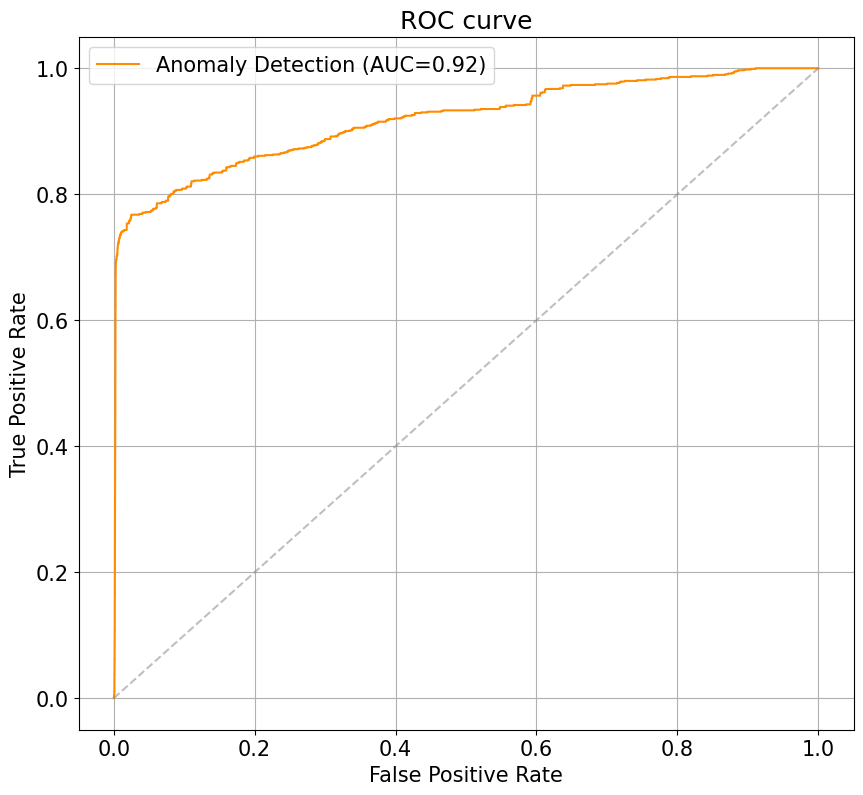

In [ ]:
plt.figure(figsize=(10,9))
plt.rcParams['font.size'] = 15
fpr,tpr,thr = roc_curve(predictions['true_class'], predictions['prob'], pos_label=None, sample_weight=None, drop_intermediate=True)

plt.grid()
plt.plot(fpr,tpr,color='darkorange')
plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f'Anomaly Detection (AUC={auc(fpr,tpr):.2f})'])

plt.title("ROC curve")
plt.show()

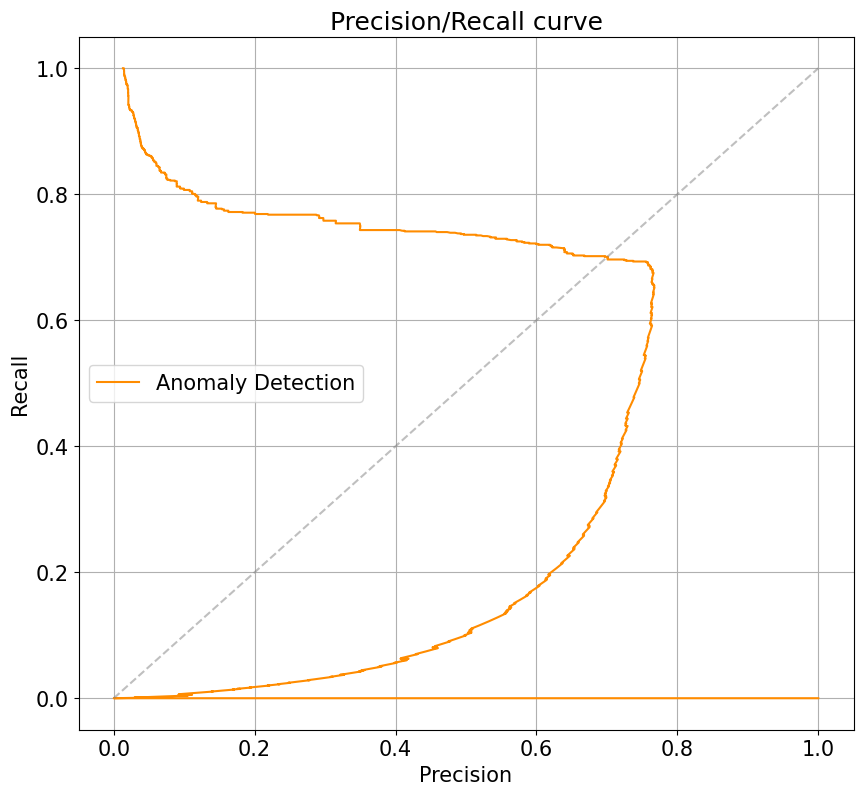

In [ ]:
plt.figure(figsize=(10,9))
plt.rcParams['font.size'] = 15
prec,rec,thr = precision_recall_curve(predictions['true_class'], predictions['prob'])

plt.grid()
plt.plot(prec,rec,color='darkorange')
plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend([f'Anomaly Detection'])

plt.title("Precision/Recall curve")
plt.show()

Best probability threshold: p=0.00%


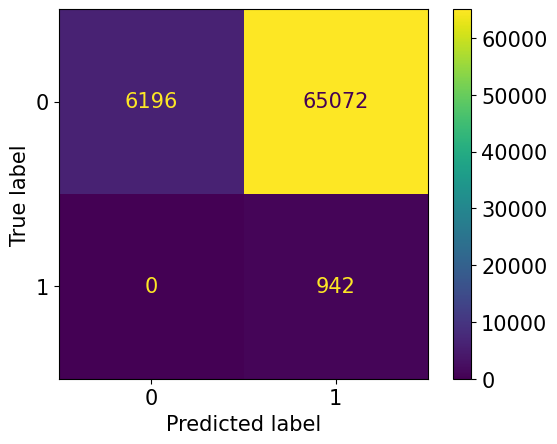


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.09      0.16     71268
           1       0.01      1.00      0.03       942

    accuracy                           0.10     72210
   macro avg       0.51      0.54      0.09     72210
weighted avg       0.99      0.10      0.16     72210



In [ ]:
th = thr[np.argmax(tpr-fpr)]
y_pred = predictions['prob']>th
y_true = predictions['true_class']

print(f"Best probability threshold: p={th*100:.2f}%")
cm = confusion_matrix(y_true,y_pred)
disp  = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print("\nClassification Report")
print(classification_report(y_true,y_pred))

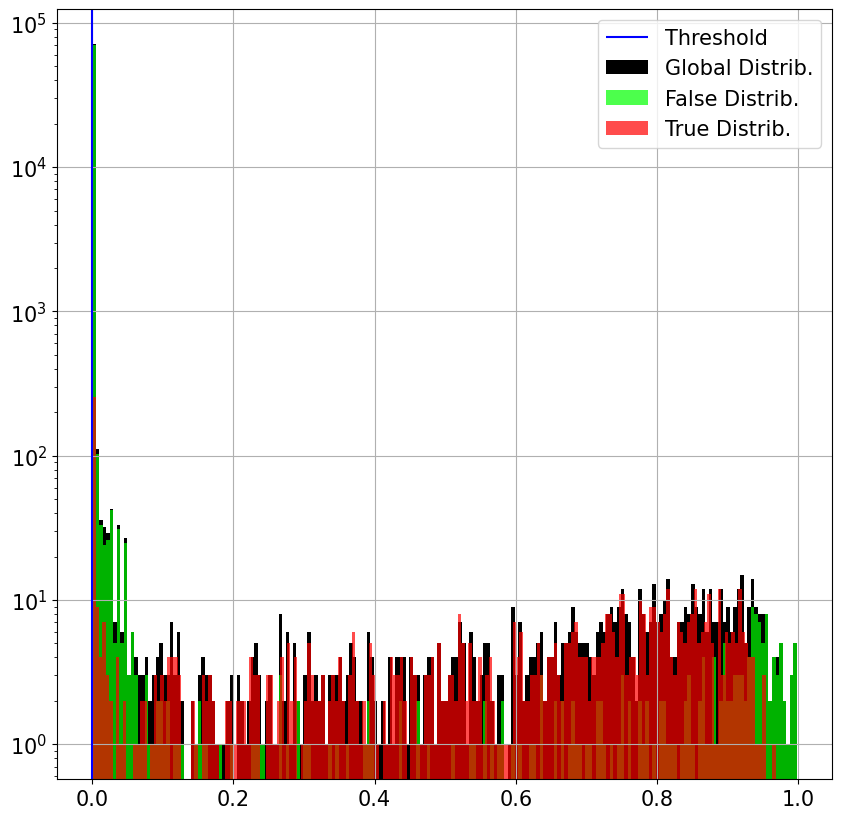

In [ ]:
plt.figure(figsize=(10,10))
plt.yscale('log')
predictions['prob'].hist(bins = 200,color='black')
predictions[predictions['true_class']==0]['prob'].hist(bins = 200,color='lime',alpha=0.7,)
predictions[predictions['true_class']==1]['prob'].hist(bins = 200,color='red',alpha=0.7)
ylim = plt.gca().get_ylim()

plt.vlines(th, *ylim,color='blue')
plt.gca().set_ylim(ylim)
plt.legend(['Threshold','Global Distrib.','False Distrib.','True Distrib.'])

In [ ]:
train_labels = []
for g in tqdm(train_loader,leave=False):
  train_labels.append(g.y)
train_labels = torch.cat(train_labels)
test_labels = []
for g in tqdm(test_loader,leave=False):
  test_labels.append(g.y)
test_labels = torch.cat(test_labels)

train_ones = len(train_labels.nonzero())
train_zeros = len(train_labels)-train_ones

test_ones = len((test_labels.nonzero()))
test_zeros = len(test_labels)-test_ones
print('\t0\t\t1')
print(f'train\t{train_zeros} ({train_zeros/len(train_labels)*100:.2f}%)\t{train_ones} ({train_ones/len(train_labels)*100:.2f}%)')
print(f'test\t{test_zeros} ({test_zeros/len(test_labels)*100:.2f}%)\t{test_ones} ({test_ones/len(test_labels)*100:.2f}%)')


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

	0		1
train	178802 (99.09%)	1636 (0.91%)
test	71268 (98.70%)	942 (1.30%)


# SETUP FUNCTIONS

In [15]:
def read_data(WINDOW_SIZE):
  data = load_metrics(AGGREGATED_METRICS_PATH)
  data = process_metrics(data,KEEPNODES,DROP_TH)
  # data = add_window_labels(data,WINDOW_SIZE)
  # data.head()
  return data

def read_jobs_and_racks(data):
  node_columns = data.columns[1:-3]
  nodes = list(node_columns.astype(int))

  racks = pd.read_json(RACKS_DATA_PATH)

  jobtable = pd.read_parquet(JOB_TABLE_PATH)[['start_time','end_time','nodes']]
  jobtable = jobtable.dropna(subset=['nodes'])
  jobtable.nodes = jobtable.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
  jobtable.nodes = jobtable.nodes.map(lambda a : np.intersect1d(a,nodes)) # Keep only jobs where the selected nodes appear
  jobtable = jobtable[jobtable.nodes.map(len)>0] # Drop rows without any node of interest
  jobtable = jobtable.reset_index() # Not really necessary, but meh
  print("Data covering the period from {} to {}".format(jobtable.start_time.min().date(),jobtable.end_time.max().date()))
  jobtable.head()
  return jobtable, racks

def build_graph(jobs):
  edge_list = jobs.nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
  edge_list = edge_list[edge_list.map(len) > 0]
  if len(edge_list) > 0:
    true_edges = np.concatenate(edge_list.values) # remove empty list and collect all
    heatmap = build_heatmap(true_edges)

  else:
    heatmap = np.zeros((980,980))
    true_edges = np.empty(0)

  src,dst = np.nonzero(heatmap)
  graph = dgl.graph((src,dst),num_nodes=980)

  eweights = torch.tensor(heatmap[heatmap.nonzero()],dtype=torch.float32)

  graph = dgl.graph((src,dst),num_nodes=980)
  graph.edata['eweight'] = eweights


  # Drop nodes not contained in the dataset
  drop_nids = [i for i in range(980) if str(i) not in data.columns]
  graph = dgl.remove_nodes(graph, drop_nids, store_ids=True)

  # Add self loops
  graph = dgl.add_self_loop(graph)
  return graph

def get_data_list(data, jobtable):
  data_list = []

  for i,row in tqdm(data.iterrows(), total=len(data)):
      timestamp = row['timestamp']
      jobs = jobtable[(jobtable['start_time']<timestamp) & (jobtable['end_time']>timestamp)]
      if len(jobs) > 0:
        graph = build_graph(jobs)
        # Graph changes, so are the weights
        eweights = graph.edata['eweight']
        edge_index = torch.stack(graph.edges())
        x = torch.tensor(np.stack(row.iloc[1:-3]),dtype = torch.float32)
        y = torch.tensor(row.iloc[-1],dtype=torch.float32)
        g = Data(edge_index=edge_index,x=x, y=y,edge_weight = eweights)
        data_list.append(g)
  return data_list

def train_test_split(data,data_list):
  TRAIN_SPLIT = 0.7

  train_size = int(len(data)*TRAIN_SPLIT)
  train_data = data_list[:train_size]
  test_data = data_list[train_size:]

  return train_data, test_data

def train(train_data, test_data):
  # Create model
  in_channels, out_channels = train_data[0].x.shape[1], 16
  model = anomaly_anticipation(in_channels,out_channels)

  tot_params = 0
  for name,param in model.named_parameters():
      print(name,param.shape,param.numel())
      tot_params += param.numel()
  print('Total trainable Params:',tot_params)

  NUM_EPOCHS = 200
  INITIAL_LR = 1e-3

  TRAIN_BATCH_SIZE = 64
  TEST_BATCH_SIZE = 64

  ES_PATIENCE = 50
  ES_MIN_DELTA = 0
  LOGGER_NAME = f'out/train.output'
  LOGPATH = f'out'

  APPLY_WEIGHT_BALANCING = True # whether to use weight balancing inside the loss

  # Select device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print('Available device:',device)

  model = model.to(device)

  # Prepare dataloaders
  train_loader = DataLoader(train_data, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
  test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)

  # Compute weight balancing
  pos_weight = None
  if APPLY_WEIGHT_BALANCING:
    train_labels = torch.cat([g.y for g in train_data])
    train_ones = len(train_labels.nonzero())
    train_zeros = len(train_labels)-train_ones
    pos_weight = torch.tensor(train_zeros/train_ones) * 100
    # pos_weight = torch.tensor(train_ones/train_zeros)


  # Set up training
  criterion = torch.nn.BCEWithLogitsLoss(weight = pos_weight)
  optimizer = torch.optim.Adam([p for p in model.parameters()],lr = INITIAL_LR)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=INITIAL_LR * 1e-1)
  trainer =  MyTrainer(model,
                       optimizer,
                       scheduler,
                       ES_PATIENCE,
                       ES_MIN_DELTA)

  trainer.train(NUM_EPOCHS,criterion,train_loader,LOGGER_NAME,device,LOGPATH)
  model.load_state_dict(torch.load('out/BestModel/best-model.pt')['model'])
  return model, test_loader

# PLOT FUNCTIONS

In [27]:
def get_predictions(model,dataloader,device):
    model.eval()

    preds = []
    y_true = []
    with torch.no_grad():
        for g in tqdm(dataloader):
            g = g.to(device)

            # Forward pass
            logits = model(g.x,g.edge_index,g.edge_weight).squeeze()

            pred = torch.sigmoid(logits)
            preds.append(pred.detach().cpu().numpy())
            y_true.append(g.y.detach().cpu().numpy())

    preds = np.concatenate(preds).astype(float)
    y_true = np.concatenate(y_true).astype(int)

    return pd.DataFrame({'prob': preds,'true_class': y_true})

def plot_roc_curve(predictions):
    plt.figure(figsize=(10,9))
    plt.rcParams['font.size'] = 15
    fpr,tpr,thr = roc_curve(predictions['true_class'], predictions['prob'], pos_label=None, sample_weight=None, drop_intermediate=True)

    plt.grid()
    plt.plot(fpr,tpr,color='darkorange')
    plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend([f'Anomaly Detection (AUC={auc(fpr,tpr):.2f})'])

    plt.title("ROC curve")
    plt.show()
    return fpr,tpr,thr

def plot_pr_curve(predictions):
    plt.figure(figsize=(10,9))
    plt.rcParams['font.size'] = 15
    prec,rec,thr = precision_recall_curve(predictions['true_class'], predictions['prob'])

    plt.grid()
    plt.plot(prec,rec,color='darkorange')
    plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend([f'Anomaly Detection'])

    plt.title("Precision/Recall curve")
    plt.show()

def plot_classification_report(predictions, thr, tpr, fpr):
    th = thr[np.argmax(tpr-fpr)]
    y_pred = predictions['prob']>th
    y_true = predictions['true_class']

    print(f"Best probability threshold: p={th*100:.2f}%")
    cm = confusion_matrix(y_true,y_pred)
    disp  = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    print("\nClassification Report")
    print(classification_report(y_true,y_pred))

def plot_distributions(predictions, th):
    plt.figure(figsize=(10,10))
    plt.yscale('log')
    predictions['prob'].hist(bins = 200,color='black')
    predictions[predictions['true_class']==0]['prob'].hist(bins = 200,color='lime',alpha=0.7,)
    predictions[predictions['true_class']==1]['prob'].hist(bins = 200,color='red',alpha=0.7)
    ylim = plt.gca().get_ylim()

    plt.vlines(th, *ylim,color='blue')
    plt.gca().set_ylim(ylim)
    plt.legend(['Threshold','Global Distrib.','False Distrib.','True Distrib.'])

# Window size 4

Train

In [9]:
data = read_data()
data = add_window_labels(data,4)
jobtable, racks = read_jobs_and_racks(data)
datalist = get_data_list(jobtable, data)



100%|██████████| 2963/2963 [00:00<00:00, 15062.77it/s]


Data covering the period from 2022-03-31 to 2022-04-30


  0%|          | 0/2963 [00:00<?, ?it/s]

In [16]:
train_data, test_data = train_test_split(data,datalist)
model, test_loader = train(train_data, test_data)

conv1.bias torch.Size([300]) 300
conv1.lin.weight torch.Size([300, 416]) 124800
conv2.bias torch.Size([100]) 100
conv2.lin.weight torch.Size([100, 300]) 30000
conv3.bias torch.Size([16]) 16
conv3.lin.weight torch.Size([16, 100]) 1600
fc1.weight torch.Size([16, 16]) 256
fc1.bias torch.Size([16]) 16
fc2.weight torch.Size([1, 16]) 16
fc2.bias torch.Size([1]) 1
Total trainable Params: 157105
Available device: cuda


  0%|          | 1/200 [00:00<02:26,  1.36it/s]

Epoch 1/200	 Train Loss: 1962.1724027089638, Train Acc at 50%: 0.9899743956372826



  1%|          | 2/200 [00:02<04:13,  1.28s/it]

Epoch 2/200	 Train Loss: 517.1645440539132, Train Acc at 50%: 0.9913987075893105



  2%|▏         | 3/200 [00:03<03:34,  1.09s/it]

Epoch 3/200	 Train Loss: 443.1098549086113, Train Acc at 50%: 0.9913987075893105



  2%|▏         | 4/200 [00:04<03:17,  1.01s/it]

Epoch 4/200	 Train Loss: 341.68707256786263, Train Acc at 50%: 0.9913987075893105



  2%|▎         | 5/200 [00:04<03:03,  1.06it/s]

Epoch 5/200	 Train Loss: 224.40581252286103, Train Acc at 50%: 0.9913987075893105



  3%|▎         | 6/200 [00:05<02:58,  1.09it/s]

Epoch 6/200	 Train Loss: 157.6670435274166, Train Acc at 50%: 0.9959764572872677



  4%|▎         | 7/200 [00:06<02:53,  1.11it/s]

Epoch 7/200	 Train Loss: 134.8678438023033, Train Acc at 50%: 0.9972178809341713



  4%|▍         | 8/200 [00:07<02:50,  1.13it/s]

Epoch 8/200	 Train Loss: 118.61278666356311, Train Acc at 50%: 0.9971292078165354



  4%|▍         | 9/200 [00:08<02:38,  1.20it/s]

Epoch 9/200	 Train Loss: 113.30130016958734, Train Acc at 50%: 0.9971070395371263



  5%|▌         | 10/200 [00:08<02:29,  1.27it/s]

Epoch 10/200	 Train Loss: 115.1326106474246, Train Acc at 50%: 0.9967080105077645



  6%|▌         | 11/200 [00:09<02:21,  1.33it/s]

Epoch 11/200	 Train Loss: 107.0756714217626, Train Acc at 50%: 0.9968077677651049



  6%|▌         | 12/200 [00:10<02:16,  1.38it/s]

Epoch 12/200	 Train Loss: 110.74345758653942, Train Acc at 50%: 0.9961759718019486



  6%|▋         | 13/200 [00:10<02:12,  1.42it/s]

Epoch 13/200	 Train Loss: 104.78595417816646, Train Acc at 50%: 0.9964198228754475



  7%|▋         | 14/200 [00:11<02:08,  1.45it/s]

Epoch 14/200	 Train Loss: 110.47488888149947, Train Acc at 50%: 0.9960540462651991



  8%|▊         | 15/200 [00:12<02:05,  1.48it/s]

Epoch 15/200	 Train Loss: 105.38121681685676, Train Acc at 50%: 0.9961316352431306



  8%|▊         | 16/200 [00:12<02:02,  1.50it/s]

Epoch 16/200	 Train Loss: 111.81579268225097, Train Acc at 50%: 0.9959376627983019



  8%|▊         | 17/200 [00:13<02:00,  1.52it/s]

Epoch 17/200	 Train Loss: 116.50879526485552, Train Acc at 50%: 0.9958600738203705



  9%|▉         | 18/200 [00:14<01:59,  1.53it/s]

Epoch 18/200	 Train Loss: 111.72667619902681, Train Acc at 50%: 0.996652589809242



 10%|▉         | 19/200 [00:14<01:58,  1.53it/s]

Epoch 19/200	 Train Loss: 104.58082000465534, Train Acc at 50%: 0.9974007692392954



 10%|█         | 20/200 [00:15<01:58,  1.52it/s]

Epoch 20/200	 Train Loss: 102.99048980813355, Train Acc at 50%: 0.9965306642724925



 10%|█         | 21/200 [00:16<01:57,  1.52it/s]

Epoch 21/200	 Train Loss: 97.75068444562675, Train Acc at 50%: 0.9977055830811692



 11%|█         | 22/200 [00:16<01:55,  1.54it/s]

Epoch 22/200	 Train Loss: 104.95156230949135, Train Acc at 50%: 0.9978607610370321



 12%|█▏        | 23/200 [00:17<01:54,  1.54it/s]

Epoch 23/200	 Train Loss: 101.09055742138574, Train Acc at 50%: 0.9980436493421563



 12%|█▏        | 24/200 [00:18<02:00,  1.46it/s]

Epoch 24/200	 Train Loss: 100.23994945632295, Train Acc at 50%: 0.9971292078165354



 12%|█▎        | 25/200 [00:20<03:01,  1.04s/it]

Epoch 25/200	 Train Loss: 98.9440583469114, Train Acc at 50%: 0.9969795719305247



 13%|█▎        | 26/200 [00:21<03:23,  1.17s/it]

Epoch 26/200	 Train Loss: 100.52174154003038, Train Acc at 50%: 0.9977000410113169



 14%|█▎        | 27/200 [00:22<03:07,  1.09s/it]

Epoch 27/200	 Train Loss: 99.38358882275352, Train Acc at 50%: 0.9979660603642249



 14%|█▍        | 28/200 [00:23<02:56,  1.02s/it]

Epoch 28/200	 Train Loss: 101.24738691406466, Train Acc at 50%: 0.9970405346988993



 14%|█▍        | 29/200 [00:24<02:40,  1.06it/s]

Epoch 29/200	 Train Loss: 98.41397044968355, Train Acc at 50%: 0.9972954699121027



 15%|█▌        | 30/200 [00:24<02:26,  1.16it/s]

Epoch 30/200	 Train Loss: 103.11274786907414, Train Acc at 50%: 0.9970793291878651



 16%|█▌        | 31/200 [00:25<02:15,  1.24it/s]

Epoch 31/200	 Train Loss: 99.7631319345149, Train Acc at 50%: 0.9979438920848158



 16%|█▌        | 32/200 [00:26<02:07,  1.32it/s]

Epoch 32/200	 Train Loss: 98.33286779946575, Train Acc at 50%: 0.9971624602356488



 16%|█▋        | 33/200 [00:26<02:02,  1.36it/s]

Epoch 33/200	 Train Loss: 95.34940533590485, Train Acc at 50%: 0.9973287223312163



 17%|█▋        | 34/200 [00:27<01:56,  1.42it/s]

Epoch 34/200	 Train Loss: 96.08556955851871, Train Acc at 50%: 0.9978663031068844



 18%|█▊        | 35/200 [00:28<01:52,  1.46it/s]

Epoch 35/200	 Train Loss: 95.51647657367073, Train Acc at 50%: 0.9970627029783083



 18%|█▊        | 36/200 [00:28<01:51,  1.47it/s]

Epoch 36/200	 Train Loss: 94.74104124408385, Train Acc at 50%: 0.9967135525776167



 18%|█▊        | 37/200 [00:29<01:49,  1.48it/s]

Epoch 37/200	 Train Loss: 92.72662632039814, Train Acc at 50%: 0.9977831720591006



 19%|█▉        | 38/200 [00:29<01:48,  1.50it/s]

Epoch 38/200	 Train Loss: 96.43415466808544, Train Acc at 50%: 0.9978441348274754



 20%|█▉        | 39/200 [00:30<01:46,  1.51it/s]

Epoch 39/200	 Train Loss: 94.62322792316475, Train Acc at 50%: 0.997212338864319



 20%|██        | 40/200 [00:31<01:44,  1.53it/s]

Epoch 40/200	 Train Loss: 93.52960019508086, Train Acc at 50%: 0.9967301787871734



 20%|██        | 41/200 [00:31<01:44,  1.53it/s]

Epoch 41/200	 Train Loss: 92.10213480530709, Train Acc at 50%: 0.9977720879193961



 21%|██        | 42/200 [00:32<01:42,  1.54it/s]

Epoch 42/200	 Train Loss: 94.76261097994879, Train Acc at 50%: 0.9978496768973276



 22%|██▏       | 43/200 [00:33<01:42,  1.54it/s]

Epoch 43/200	 Train Loss: 93.32359037453308, Train Acc at 50%: 0.9970183664194904



 22%|██▏       | 44/200 [00:33<01:45,  1.47it/s]

Epoch 44/200	 Train Loss: 91.94564337888914, Train Acc at 50%: 0.996652589809242



 22%|██▎       | 45/200 [00:34<01:48,  1.43it/s]

Epoch 45/200	 Train Loss: 92.96865405291568, Train Acc at 50%: 0.9977997982686574



 23%|██▎       | 46/200 [00:35<01:49,  1.40it/s]

Epoch 46/200	 Train Loss: 94.46394883561112, Train Acc at 50%: 0.9978995555259979



 24%|██▎       | 47/200 [00:36<01:52,  1.36it/s]

Epoch 47/200	 Train Loss: 92.81747747148606, Train Acc at 50%: 0.996874272603332



 24%|██▍       | 48/200 [00:37<01:53,  1.34it/s]

Epoch 48/200	 Train Loss: 90.55108125782817, Train Acc at 50%: 0.9976723306620556



 24%|██▍       | 49/200 [00:37<01:54,  1.32it/s]

Epoch 49/200	 Train Loss: 94.43630499118811, Train Acc at 50%: 0.9977776299892483



 25%|██▌       | 50/200 [00:38<01:55,  1.30it/s]

Epoch 50/200	 Train Loss: 93.28052849178111, Train Acc at 50%: 0.9971735443753533



 26%|██▌       | 51/200 [00:39<01:57,  1.27it/s]

Epoch 51/200	 Train Loss: 91.01295735931456, Train Acc at 50%: 0.9968354781143661



 26%|██▌       | 52/200 [00:40<01:55,  1.28it/s]

Epoch 52/200	 Train Loss: 90.28749487358539, Train Acc at 50%: 0.9978441348274754



 26%|██▋       | 53/200 [00:40<01:55,  1.27it/s]

Epoch 53/200	 Train Loss: 92.76705017790044, Train Acc at 50%: 0.9968853567430364



 27%|██▋       | 54/200 [00:41<01:57,  1.24it/s]

Epoch 54/200	 Train Loss: 89.87005508817433, Train Acc at 50%: 0.9975060685664882



 28%|██▊       | 55/200 [00:42<01:58,  1.23it/s]

Epoch 55/200	 Train Loss: 92.23527194936764, Train Acc at 50%: 0.9978219665480663



 28%|██▊       | 56/200 [00:43<01:58,  1.22it/s]

Epoch 56/200	 Train Loss: 91.9795275939658, Train Acc at 50%: 0.9974949844267837



 28%|██▊       | 57/200 [00:44<02:00,  1.19it/s]

Epoch 57/200	 Train Loss: 89.1009266340793, Train Acc at 50%: 0.9970571609084561



 29%|██▉       | 58/200 [00:45<02:01,  1.17it/s]

Epoch 58/200	 Train Loss: 88.68636318292155, Train Acc at 50%: 0.9978108824083619



 30%|██▉       | 59/200 [00:46<01:57,  1.20it/s]

Epoch 59/200	 Train Loss: 89.85048603952605, Train Acc at 50%: 0.9977997982686574



 30%|███       | 60/200 [00:46<01:51,  1.26it/s]

Epoch 60/200	 Train Loss: 90.09131114288564, Train Acc at 50%: 0.9969019829525931



 30%|███       | 61/200 [00:47<01:46,  1.31it/s]

Epoch 61/200	 Train Loss: 87.79129119143418, Train Acc at 50%: 0.9977443775701349



 31%|███       | 62/200 [00:48<01:41,  1.36it/s]

Epoch 62/200	 Train Loss: 92.19245391768918, Train Acc at 50%: 0.9978275086179186



 32%|███▏      | 63/200 [00:48<01:39,  1.38it/s]

Epoch 63/200	 Train Loss: 90.35964153892196, Train Acc at 50%: 0.9974063113091477



 32%|███▏      | 64/200 [00:49<01:42,  1.33it/s]

Epoch 64/200	 Train Loss: 87.68309336170873, Train Acc at 50%: 0.9972677595628415



 32%|███▎      | 65/200 [00:50<01:48,  1.24it/s]

Epoch 65/200	 Train Loss: 86.70405346988993, Train Acc at 50%: 0.9977166672208736



 33%|███▎      | 66/200 [00:51<01:49,  1.22it/s]

Epoch 66/200	 Train Loss: 87.55275496292356, Train Acc at 50%: 0.9978219665480663



 34%|███▎      | 67/200 [00:52<01:55,  1.15it/s]

Epoch 67/200	 Train Loss: 87.56598388366086, Train Acc at 50%: 0.9974229375187045



 34%|███▍      | 68/200 [00:53<01:55,  1.15it/s]

Epoch 68/200	 Train Loss: 90.25611567408195, Train Acc at 50%: 0.9967301787871734



 34%|███▍      | 69/200 [00:54<01:52,  1.17it/s]

Epoch 69/200	 Train Loss: 86.78995555259978, Train Acc at 50%: 0.9977443775701349



 35%|███▌      | 70/200 [00:54<01:48,  1.20it/s]

Epoch 70/200	 Train Loss: 96.59250268790387, Train Acc at 50%: 0.9969684877908201



 36%|███▌      | 71/200 [00:55<01:52,  1.15it/s]

Epoch 71/200	 Train Loss: 90.77821744865273, Train Acc at 50%: 0.997544863055454



 36%|███▌      | 72/200 [00:56<01:57,  1.09it/s]

Epoch 72/200	 Train Loss: 87.02998813997051, Train Acc at 50%: 0.9976169099635331



 36%|███▋      | 73/200 [00:57<01:59,  1.06it/s]

Epoch 73/200	 Train Loss: 86.1819018166905, Train Acc at 50%: 0.9977942561988051



 37%|███▋      | 74/200 [00:58<01:58,  1.06it/s]

Epoch 74/200	 Train Loss: 85.81766590186103, Train Acc at 50%: 0.9975614892650106



 38%|███▊      | 75/200 [00:59<01:55,  1.09it/s]

Epoch 75/200	 Train Loss: 84.92191777785168, Train Acc at 50%: 0.9977610037796917



 38%|███▊      | 76/200 [01:00<01:55,  1.08it/s]

Epoch 76/200	 Train Loss: 84.9592048238176, Train Acc at 50%: 0.9977776299892483



 38%|███▊      | 77/200 [01:01<01:46,  1.15it/s]

Epoch 77/200	 Train Loss: 84.48201598332945, Train Acc at 50%: 0.9974617320076702



 39%|███▉      | 78/200 [01:02<01:39,  1.23it/s]

Epoch 78/200	 Train Loss: 83.5997073787118, Train Acc at 50%: 0.9978164244782142



 40%|███▉      | 79/200 [01:02<01:33,  1.29it/s]

Epoch 79/200	 Train Loss: 84.40333521763708, Train Acc at 50%: 0.9977166672208736



 40%|████      | 80/200 [01:03<01:29,  1.35it/s]

Epoch 80/200	 Train Loss: 83.53790221571953, Train Acc at 50%: 0.9976169099635331



 40%|████      | 81/200 [01:04<01:25,  1.38it/s]

Epoch 81/200	 Train Loss: 82.19020937939902, Train Acc at 50%: 0.9978164244782142



 41%|████      | 82/200 [01:04<01:22,  1.43it/s]

Epoch 82/200	 Train Loss: 83.03730367217548, Train Acc at 50%: 0.9976446203127944



 42%|████▏     | 83/200 [01:05<01:20,  1.45it/s]

Epoch 83/200	 Train Loss: 82.09285738037443, Train Acc at 50%: 0.9976834148017601



 42%|████▏     | 84/200 [01:06<01:19,  1.47it/s]

Epoch 84/200	 Train Loss: 81.95885013134705, Train Acc at 50%: 0.9978275086179186



 42%|████▎     | 85/200 [01:06<01:18,  1.47it/s]

Epoch 85/200	 Train Loss: 82.08873408040435, Train Acc at 50%: 0.9976169099635331



 43%|████▎     | 86/200 [01:07<01:18,  1.46it/s]

Epoch 86/200	 Train Loss: 80.49658608497101, Train Acc at 50%: 0.9977388355002826



 44%|████▎     | 87/200 [01:08<01:17,  1.46it/s]

Epoch 87/200	 Train Loss: 82.03793546813864, Train Acc at 50%: 0.9978275086179186



 44%|████▍     | 88/200 [01:08<01:16,  1.47it/s]

Epoch 88/200	 Train Loss: 82.33840432724814, Train Acc at 50%: 0.997212338864319



 44%|████▍     | 89/200 [01:09<01:15,  1.47it/s]

Epoch 89/200	 Train Loss: 79.29293164411044, Train Acc at 50%: 0.9978275086179186



 45%|████▌     | 90/200 [01:10<01:18,  1.41it/s]

Epoch 90/200	 Train Loss: 80.41283432536383, Train Acc at 50%: 0.9976667885922034



 46%|████▌     | 91/200 [01:10<01:19,  1.37it/s]

Epoch 91/200	 Train Loss: 79.16872277458185, Train Acc at 50%: 0.9978496768973276



 46%|████▌     | 92/200 [01:11<01:21,  1.33it/s]

Epoch 92/200	 Train Loss: 79.66151808377393, Train Acc at 50%: 0.9976113678936809



 46%|████▋     | 93/200 [01:12<01:21,  1.32it/s]

Epoch 93/200	 Train Loss: 78.3064930890389, Train Acc at 50%: 0.9978496768973276



 47%|████▋     | 94/200 [01:13<01:20,  1.31it/s]

Epoch 94/200	 Train Loss: 79.1984393531296, Train Acc at 50%: 0.9976501623826467



 48%|████▊     | 95/200 [01:14<01:22,  1.27it/s]

Epoch 95/200	 Train Loss: 78.22747979915539, Train Acc at 50%: 0.9978441348274754



 48%|████▊     | 96/200 [01:15<01:25,  1.22it/s]

Epoch 96/200	 Train Loss: 79.09863221716047, Train Acc at 50%: 0.9976002837539765



 48%|████▊     | 97/200 [01:15<01:24,  1.22it/s]

Epoch 97/200	 Train Loss: 77.36487325286248, Train Acc at 50%: 0.9978496768973276



 49%|████▉     | 98/200 [01:16<01:19,  1.28it/s]

Epoch 98/200	 Train Loss: 78.09086777729746, Train Acc at 50%: 0.9977997982686574



 50%|████▉     | 99/200 [01:17<01:16,  1.32it/s]

Epoch 99/200	 Train Loss: 77.45653354614882, Train Acc at 50%: 0.9976723306620556



 50%|█████     | 100/200 [01:17<01:13,  1.36it/s]

Epoch 100/200	 Train Loss: 77.62752302730024, Train Acc at 50%: 0.9978330506877708



 50%|█████     | 101/200 [01:18<01:11,  1.39it/s]

Epoch 101/200	 Train Loss: 76.99894700672807, Train Acc at 50%: 0.9976667885922034



 51%|█████     | 102/200 [01:19<01:10,  1.40it/s]

Epoch 102/200	 Train Loss: 76.4118755472794, Train Acc at 50%: 0.9977720879193961



 52%|█████▏    | 103/200 [01:20<01:08,  1.42it/s]

Epoch 103/200	 Train Loss: 75.95456611135127, Train Acc at 50%: 0.9978552189671799



 52%|█████▏    | 104/200 [01:20<01:06,  1.45it/s]

Epoch 104/200	 Train Loss: 76.17581108192287, Train Acc at 50%: 0.9977111251510214



 52%|█████▎    | 105/200 [01:21<01:06,  1.44it/s]

Epoch 105/200	 Train Loss: 75.10109843824472, Train Acc at 50%: 0.9978552189671799



 53%|█████▎    | 106/200 [01:22<01:05,  1.44it/s]

Epoch 106/200	 Train Loss: 76.48238730200956, Train Acc at 50%: 0.9977831720591006



 54%|█████▎    | 107/200 [01:22<01:04,  1.45it/s]

Epoch 107/200	 Train Loss: 75.91884192908367, Train Acc at 50%: 0.9977665458495439



 54%|█████▍    | 108/200 [01:23<01:03,  1.46it/s]

Epoch 108/200	 Train Loss: 75.37338033008568, Train Acc at 50%: 0.9978385927576231



 55%|█████▍    | 109/200 [01:24<01:02,  1.46it/s]

Epoch 109/200	 Train Loss: 74.81327658253805, Train Acc at 50%: 0.9978663031068844



 55%|█████▌    | 110/200 [01:24<01:01,  1.47it/s]

Epoch 110/200	 Train Loss: 74.68528802137023, Train Acc at 50%: 0.9976889568716124



 56%|█████▌    | 111/200 [01:25<01:01,  1.46it/s]

Epoch 111/200	 Train Loss: 73.91721256054711, Train Acc at 50%: 0.9978552189671799



 56%|█████▌    | 112/200 [01:26<01:03,  1.38it/s]

Epoch 112/200	 Train Loss: 74.4015451290748, Train Acc at 50%: 0.9978053403385096



 56%|█████▋    | 113/200 [01:27<01:04,  1.34it/s]

Epoch 113/200	 Train Loss: 73.5338675888671, Train Acc at 50%: 0.9978663031068844



 57%|█████▋    | 114/200 [01:27<01:06,  1.30it/s]

Epoch 114/200	 Train Loss: 73.69072479189528, Train Acc at 50%: 0.9977720879193961



 57%|█████▊    | 115/200 [01:28<01:06,  1.28it/s]

Epoch 115/200	 Train Loss: 73.25451401589466, Train Acc at 50%: 0.9978607610370321



 58%|█████▊    | 116/200 [01:29<01:06,  1.26it/s]

Epoch 116/200	 Train Loss: 73.39528259014176, Train Acc at 50%: 0.9976667885922034



 58%|█████▊    | 117/200 [01:30<01:07,  1.23it/s]

Epoch 117/200	 Train Loss: 72.5925802768818, Train Acc at 50%: 0.9978773872465888



 59%|█████▉    | 118/200 [01:31<01:07,  1.21it/s]

Epoch 118/200	 Train Loss: 72.64853301411011, Train Acc at 50%: 0.9977942561988051



 60%|█████▉    | 119/200 [01:32<01:06,  1.22it/s]

Epoch 119/200	 Train Loss: 72.13929992573627, Train Acc at 50%: 0.9978385927576231



 60%|██████    | 120/200 [01:32<01:03,  1.26it/s]

Epoch 120/200	 Train Loss: 71.99653620634234, Train Acc at 50%: 0.9978275086179186



 60%|██████    | 121/200 [01:33<01:00,  1.30it/s]

Epoch 121/200	 Train Loss: 71.8275806648267, Train Acc at 50%: 0.9978164244782142



 61%|██████    | 122/200 [01:34<00:59,  1.31it/s]

Epoch 122/200	 Train Loss: 71.42870127135082, Train Acc at 50%: 0.9978275086179186



 62%|██████▏   | 123/200 [01:34<00:56,  1.36it/s]

Epoch 123/200	 Train Loss: 71.47073232911028, Train Acc at 50%: 0.9978164244782142



 62%|██████▏   | 124/200 [01:35<00:55,  1.38it/s]

Epoch 124/200	 Train Loss: 71.12751194316053, Train Acc at 50%: 0.9978385927576231



 62%|██████▎   | 125/200 [01:36<00:53,  1.41it/s]

Epoch 125/200	 Train Loss: 71.13784236136512, Train Acc at 50%: 0.9977443775701349



 63%|██████▎   | 126/200 [01:37<00:52,  1.41it/s]

Epoch 126/200	 Train Loss: 70.65065562686353, Train Acc at 50%: 0.9978607610370321



 64%|██████▎   | 127/200 [01:37<00:51,  1.42it/s]

Epoch 127/200	 Train Loss: 70.6460390826766, Train Acc at 50%: 0.9978164244782142



 64%|██████▍   | 128/200 [01:38<00:50,  1.44it/s]

Epoch 128/200	 Train Loss: 70.42753743668185, Train Acc at 50%: 0.9978552189671799



 64%|██████▍   | 129/200 [01:39<00:49,  1.44it/s]

Epoch 129/200	 Train Loss: 70.37274299205268, Train Acc at 50%: 0.9977055830811692



 65%|██████▌   | 130/200 [01:40<01:04,  1.08it/s]

Epoch 130/200	 Train Loss: 69.77725867056829, Train Acc at 50%: 0.9978829293164411



 66%|██████▌   | 131/200 [01:41<00:59,  1.16it/s]

Epoch 131/200	 Train Loss: 70.00484376905086, Train Acc at 50%: 0.9978385927576231



 66%|██████▌   | 132/200 [01:42<00:57,  1.19it/s]

Epoch 132/200	 Train Loss: 69.63106440993582, Train Acc at 50%: 0.9978829293164411



 66%|██████▋   | 133/200 [01:42<00:55,  1.22it/s]

Epoch 133/200	 Train Loss: 70.13309280750174, Train Acc at 50%: 0.9976446203127944



 67%|██████▋   | 134/200 [01:43<00:53,  1.22it/s]

Epoch 134/200	 Train Loss: 69.27748589543222, Train Acc at 50%: 0.9978884713862933



 68%|██████▊   | 135/200 [01:44<00:52,  1.24it/s]

Epoch 135/200	 Train Loss: 69.87744820935723, Train Acc at 50%: 0.9977776299892483



 68%|██████▊   | 136/200 [01:45<00:51,  1.23it/s]

Epoch 136/200	 Train Loss: 69.05512696882032, Train Acc at 50%: 0.9979438920848158



 68%|██████▊   | 137/200 [01:46<00:51,  1.23it/s]

Epoch 137/200	 Train Loss: 69.59662598787395, Train Acc at 50%: 0.9977111251510214



 69%|██████▉   | 138/200 [01:46<00:51,  1.21it/s]

Epoch 138/200	 Train Loss: 68.87316418936145, Train Acc at 50%: 0.9979217238054069



 70%|██████▉   | 139/200 [01:47<00:51,  1.19it/s]

Epoch 139/200	 Train Loss: 69.78405879027699, Train Acc at 50%: 0.9976279941032377



 70%|███████   | 140/200 [01:48<00:49,  1.22it/s]

Epoch 140/200	 Train Loss: 68.51924206652701, Train Acc at 50%: 0.9979494341546681



 70%|███████   | 141/200 [01:49<00:46,  1.28it/s]

Epoch 141/200	 Train Loss: 68.72223145900531, Train Acc at 50%: 0.9977831720591006



 71%|███████   | 142/200 [01:50<00:44,  1.31it/s]

Epoch 142/200	 Train Loss: 68.41718485019786, Train Acc at 50%: 0.9979217238054069



 72%|███████▏  | 143/200 [01:50<00:42,  1.34it/s]

Epoch 143/200	 Train Loss: 69.12500692758732, Train Acc at 50%: 0.9976113678936809



 72%|███████▏  | 144/200 [01:51<00:41,  1.36it/s]

Epoch 144/200	 Train Loss: 68.05042175151576, Train Acc at 50%: 0.9979383500149636



 72%|███████▎  | 145/200 [01:52<00:39,  1.40it/s]

Epoch 145/200	 Train Loss: 68.26351433733471, Train Acc at 50%: 0.9978108824083619



 73%|███████▎  | 146/200 [01:52<00:38,  1.42it/s]

Epoch 146/200	 Train Loss: 68.13151331759386, Train Acc at 50%: 0.9978940134561456



 74%|███████▎  | 147/200 [01:53<00:37,  1.42it/s]

Epoch 147/200	 Train Loss: 68.26319289728328, Train Acc at 50%: 0.9976612465223512



 74%|███████▍  | 148/200 [01:54<00:36,  1.42it/s]

Epoch 148/200	 Train Loss: 67.63938305678404, Train Acc at 50%: 0.9979328079451113



 74%|███████▍  | 149/200 [01:54<00:35,  1.44it/s]

Epoch 149/200	 Train Loss: 68.33522317915295, Train Acc at 50%: 0.9977443775701349



 75%|███████▌  | 150/200 [01:55<00:34,  1.44it/s]

Epoch 150/200	 Train Loss: 67.92315920149858, Train Acc at 50%: 0.9978995555259979



 76%|███████▌  | 151/200 [01:56<00:34,  1.44it/s]

Epoch 151/200	 Train Loss: 67.62291202518317, Train Acc at 50%: 0.9977443775701349



 76%|███████▌  | 152/200 [01:56<00:33,  1.43it/s]

Epoch 152/200	 Train Loss: 66.85191589354793, Train Acc at 50%: 0.9979050975958501



 76%|███████▋  | 153/200 [01:57<00:32,  1.44it/s]

Epoch 153/200	 Train Loss: 67.11490373424667, Train Acc at 50%: 0.9978164244782142



 77%|███████▋  | 154/200 [01:58<00:32,  1.40it/s]

Epoch 154/200	 Train Loss: 66.98461521409016, Train Acc at 50%: 0.9978164244782142



 78%|███████▊  | 155/200 [01:59<00:33,  1.34it/s]

Epoch 155/200	 Train Loss: 66.88820536694044, Train Acc at 50%: 0.9978053403385096



 78%|███████▊  | 156/200 [02:00<00:33,  1.30it/s]

Epoch 156/200	 Train Loss: 66.71172369456545, Train Acc at 50%: 0.9978884713862933



 78%|███████▊  | 157/200 [02:00<00:33,  1.27it/s]

Epoch 157/200	 Train Loss: 66.86712887529234, Train Acc at 50%: 0.9977942561988051



 79%|███████▉  | 158/200 [02:01<00:33,  1.25it/s]

Epoch 158/200	 Train Loss: 66.40799055631297, Train Acc at 50%: 0.9978718451767367



 80%|███████▉  | 159/200 [02:02<00:32,  1.26it/s]

Epoch 159/200	 Train Loss: 66.86380917545085, Train Acc at 50%: 0.9977332934304304



 80%|████████  | 160/200 [02:03<00:33,  1.20it/s]

Epoch 160/200	 Train Loss: 66.43798423835334, Train Acc at 50%: 0.9978496768973276



 80%|████████  | 161/200 [02:04<00:33,  1.16it/s]

Epoch 161/200	 Train Loss: 66.47630210931179, Train Acc at 50%: 0.9978385927576231



 81%|████████  | 162/200 [02:05<00:31,  1.20it/s]

Epoch 162/200	 Train Loss: 66.20695751449252, Train Acc at 50%: 0.9978773872465888



 82%|████████▏ | 163/200 [02:05<00:29,  1.25it/s]

Epoch 163/200	 Train Loss: 66.61479843491948, Train Acc at 50%: 0.9978275086179186



 82%|████████▏ | 164/200 [02:06<00:28,  1.28it/s]

Epoch 164/200	 Train Loss: 66.11920992252186, Train Acc at 50%: 0.9978773872465888



 82%|████████▎ | 165/200 [02:07<00:26,  1.32it/s]

Epoch 165/200	 Train Loss: 67.05340892716612, Train Acc at 50%: 0.9977222092907259



 83%|████████▎ | 166/200 [02:07<00:25,  1.34it/s]

Epoch 166/200	 Train Loss: 66.11206065241247, Train Acc at 50%: 0.9978496768973276



 84%|████████▎ | 167/200 [02:08<00:23,  1.38it/s]

Epoch 167/200	 Train Loss: 65.90908788614372, Train Acc at 50%: 0.9978607610370321



 84%|████████▍ | 168/200 [02:09<00:22,  1.40it/s]

Epoch 168/200	 Train Loss: 66.11824560236757, Train Acc at 50%: 0.9978607610370321



 84%|████████▍ | 169/200 [02:10<00:22,  1.41it/s]

Epoch 169/200	 Train Loss: 65.84335893769605, Train Acc at 50%: 0.9978552189671799



 85%|████████▌ | 170/200 [02:10<00:21,  1.42it/s]

Epoch 170/200	 Train Loss: 65.45367383810506, Train Acc at 50%: 0.9978385927576231



 86%|████████▌ | 171/200 [02:11<00:20,  1.44it/s]

Epoch 171/200	 Train Loss: 65.59282967002517, Train Acc at 50%: 0.9978330506877708



 86%|████████▌ | 172/200 [02:12<00:19,  1.44it/s]

Epoch 172/200	 Train Loss: 65.12859264678173, Train Acc at 50%: 0.9978552189671799



 86%|████████▋ | 173/200 [02:12<00:18,  1.46it/s]

Epoch 173/200	 Train Loss: 65.3363315931234, Train Acc at 50%: 0.9978441348274754



 87%|████████▋ | 174/200 [02:13<00:18,  1.44it/s]

Epoch 174/200	 Train Loss: 64.96207561600106, Train Acc at 50%: 0.9978607610370321



 88%|████████▊ | 175/200 [02:14<00:17,  1.45it/s]

Epoch 175/200	 Train Loss: 65.60336514481429, Train Acc at 50%: 0.9977388355002826



 88%|████████▊ | 176/200 [02:14<00:17,  1.40it/s]

Epoch 176/200	 Train Loss: 64.82141234108114, Train Acc at 50%: 0.9978552189671799



 88%|████████▊ | 177/200 [02:15<00:16,  1.36it/s]

Epoch 177/200	 Train Loss: 64.89317660359791, Train Acc at 50%: 0.9978552189671799



 89%|████████▉ | 178/200 [02:16<00:16,  1.31it/s]

Epoch 178/200	 Train Loss: 64.8165186934016, Train Acc at 50%: 0.9978829293164411



 90%|████████▉ | 179/200 [02:17<00:16,  1.28it/s]

Epoch 179/200	 Train Loss: 64.57788270763365, Train Acc at 50%: 0.9978773872465888



 90%|█████████ | 180/200 [02:18<00:15,  1.29it/s]

Epoch 180/200	 Train Loss: 64.67360533812167, Train Acc at 50%: 0.9978663031068844



 90%|█████████ | 181/200 [02:18<00:14,  1.27it/s]

Epoch 181/200	 Train Loss: 64.3541936842572, Train Acc at 50%: 0.9978940134561456



 91%|█████████ | 182/200 [02:19<00:14,  1.25it/s]

Epoch 182/200	 Train Loss: 64.60127578447998, Train Acc at 50%: 0.9978219665480663



 92%|█████████▏| 183/200 [02:20<00:14,  1.19it/s]

Epoch 183/200	 Train Loss: 64.19182212172602, Train Acc at 50%: 0.9978940134561456



 92%|█████████▏| 184/200 [02:21<00:13,  1.17it/s]

Epoch 184/200	 Train Loss: 64.16784158547534, Train Acc at 50%: 0.9978940134561456



 92%|█████████▎| 185/200 [02:22<00:12,  1.21it/s]

Epoch 185/200	 Train Loss: 64.10005098704264, Train Acc at 50%: 0.9978940134561456



 93%|█████████▎| 186/200 [02:23<00:11,  1.24it/s]

Epoch 186/200	 Train Loss: 64.13595251554551, Train Acc at 50%: 0.9978275086179186



 94%|█████████▎| 187/200 [02:23<00:10,  1.28it/s]

Epoch 187/200	 Train Loss: 63.82574623970561, Train Acc at 50%: 0.9978995555259979



 94%|█████████▍| 188/200 [02:24<00:09,  1.33it/s]

Epoch 188/200	 Train Loss: 63.952310488921405, Train Acc at 50%: 0.9978663031068844



 94%|█████████▍| 189/200 [02:25<00:08,  1.35it/s]

Epoch 189/200	 Train Loss: 63.832247087642294, Train Acc at 50%: 0.9978663031068844



 95%|█████████▌| 190/200 [02:25<00:07,  1.37it/s]

Epoch 190/200	 Train Loss: 63.68835278599852, Train Acc at 50%: 0.9978829293164411



 96%|█████████▌| 191/200 [02:26<00:06,  1.37it/s]

Epoch 191/200	 Train Loss: 63.64979106396657, Train Acc at 50%: 0.9978884713862933



 96%|█████████▌| 192/200 [02:27<00:05,  1.38it/s]

Epoch 192/200	 Train Loss: 63.65449073920128, Train Acc at 50%: 0.9978663031068844



 96%|█████████▋| 193/200 [02:28<00:05,  1.39it/s]

Epoch 193/200	 Train Loss: 63.503652224032635, Train Acc at 50%: 0.9978940134561456



 97%|█████████▋| 194/200 [02:28<00:04,  1.43it/s]

Epoch 194/200	 Train Loss: 63.52376993759629, Train Acc at 50%: 0.9978718451767367



 98%|█████████▊| 195/200 [02:29<00:03,  1.42it/s]

Epoch 195/200	 Train Loss: 63.42568084328135, Train Acc at 50%: 0.9978995555259979



 98%|█████████▊| 196/200 [02:30<00:02,  1.43it/s]

Epoch 196/200	 Train Loss: 63.423042818031675, Train Acc at 50%: 0.9978884713862933



 98%|█████████▊| 197/200 [02:30<00:02,  1.43it/s]

Epoch 197/200	 Train Loss: 63.300906682627826, Train Acc at 50%: 0.9978995555259979



 99%|█████████▉| 198/200 [02:31<00:01,  1.41it/s]

Epoch 198/200	 Train Loss: 63.36482891630366, Train Acc at 50%: 0.9979106396657024



100%|█████████▉| 199/200 [02:32<00:00,  1.33it/s]

Epoch 199/200	 Train Loss: 63.21872887085869, Train Acc at 50%: 0.9978773872465888



100%|██████████| 200/200 [02:33<00:00,  1.30it/s]

Epoch 200/200	 Train Loss: 63.15464037508729, Train Acc at 50%: 0.997927265875259


In [18]:
predictions = get_predictions(model,test_loader,'cuda')
predictions.to_csv('predictions.csv')

  0%|          | 0/13 [00:00<?, ?it/s]

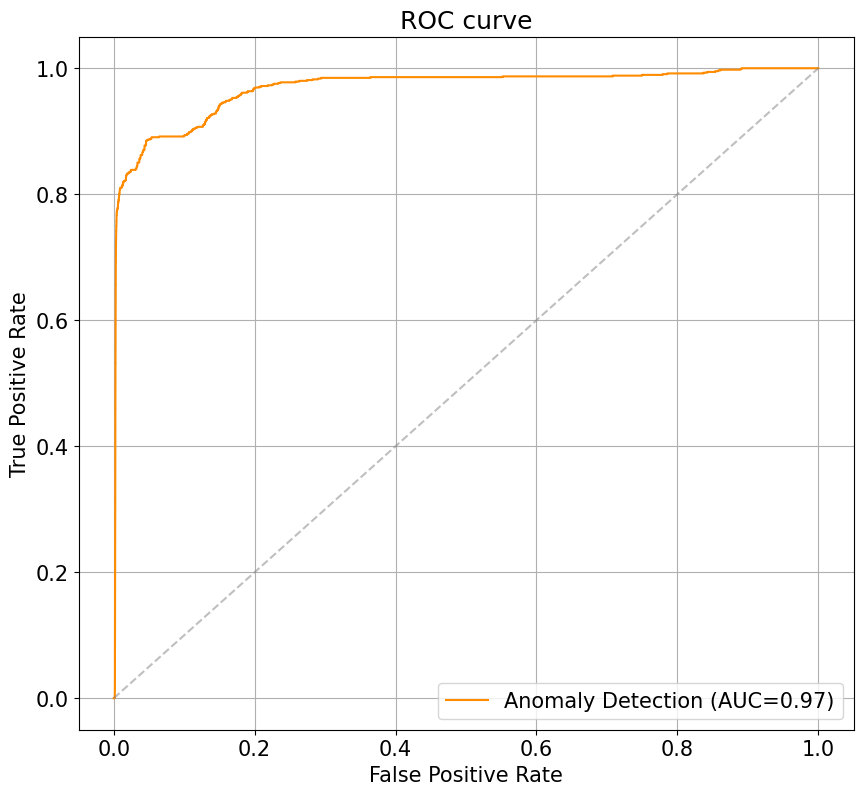

In [23]:
fpr,tpr,thr = plot_roc_curve(predictions)

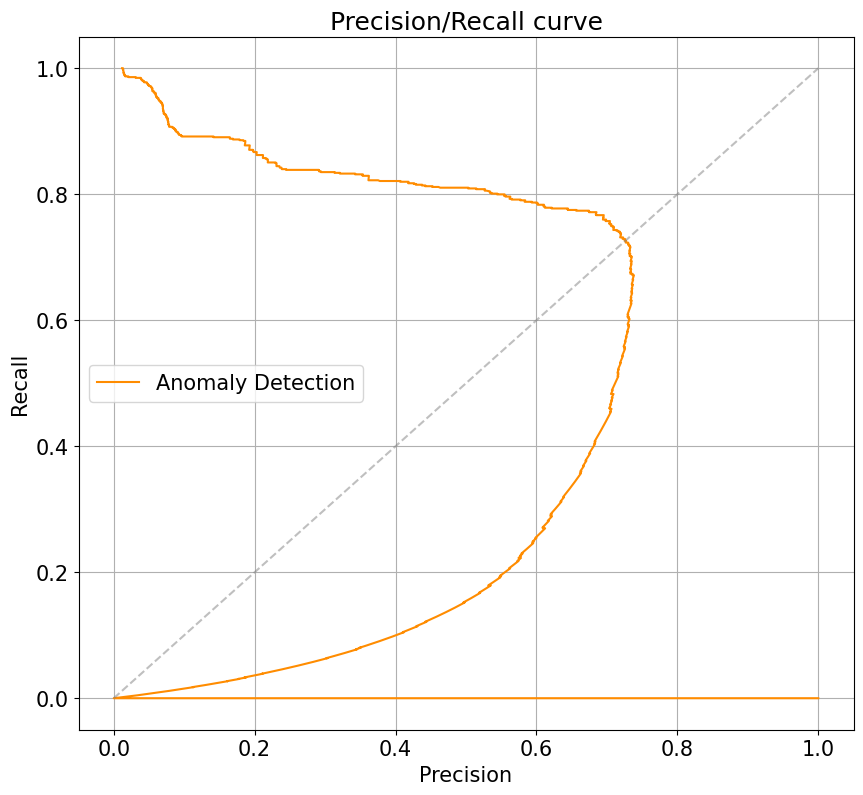

In [20]:
plot_pr_curve(predictions)

Best probability threshold: p=91.09%


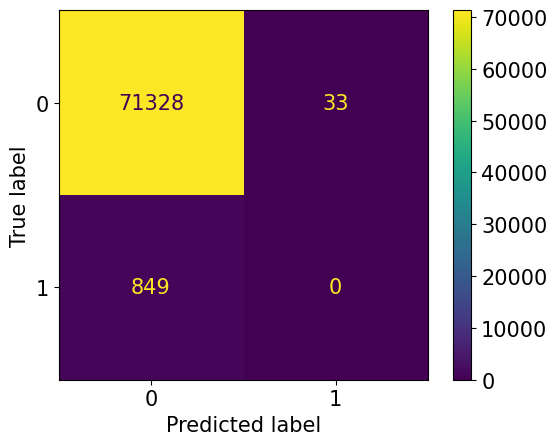


Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     71361
           1       0.00      0.00      0.00       849

    accuracy                           0.99     72210
   macro avg       0.49      0.50      0.50     72210
weighted avg       0.98      0.99      0.98     72210



In [24]:
plot_classification_report(predictions,fpr,tpr,thr)

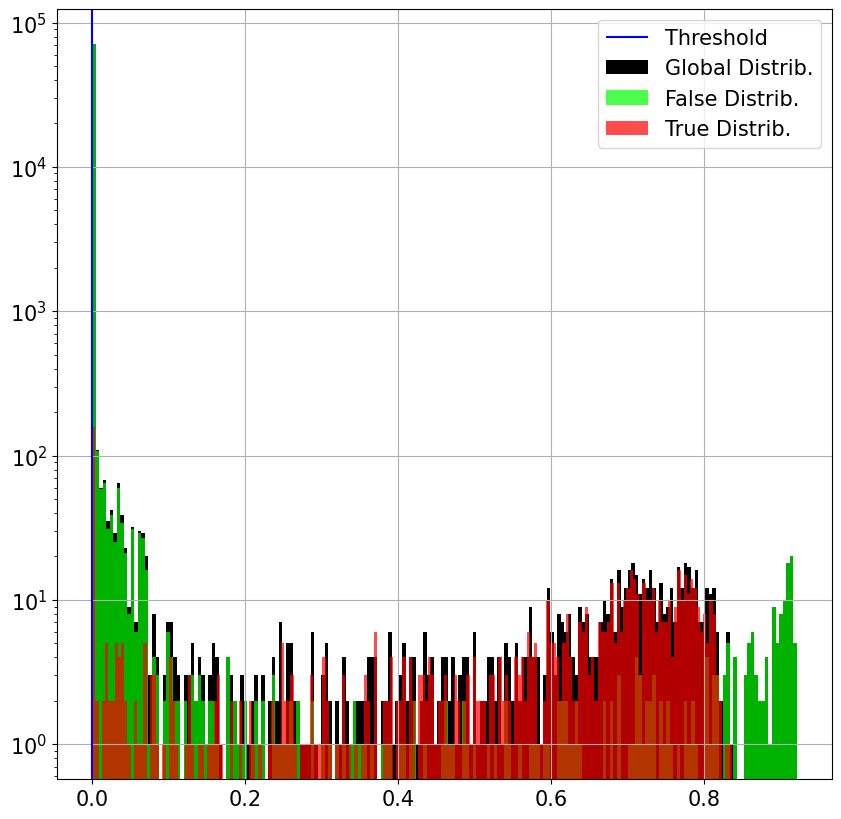

In [30]:
th = thr[np.argmax(tpr-fpr)]
plot_distributions(predictions, th)